In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import csv
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

## Helper functions

In [3]:
def read_data(file, att='open'):
    """ Read the specified attribute from data file.
        Default is 'open' attribute. 
    """
    
    df = pd.read_csv(file)
    return [float(x) for x in df[att]]

In [4]:
def get_Vectors(data):
    """ Extract V vectors from data (list). Each vector is represented
        as a sublist of coordinates [left_x, left_y, right_x, right_y],
        assuming that the dip of the V is at coordinate (0, 0). 
    """
    
    # Get start index; ignore first increase
    st = 1
    while data[st] >= data[st-1]:
        st = st+1
    st -= 1
    
    Vs = [] # list of all V vectors
    Pts = [st+1]
    i = st+1
    down = True
    while i < len(data):
        if down:
            if data[i] > data[i-1]:
                V = [st-(i-1), data[st]-data[i-1]] # left vector coordinates
                dip = i-1
                down = False
            i += 1
        else:
            if data[i] < data[i-1]:
                V = V + [(i-1)-dip, data[i-1]-data[dip]] # right vector coordinates
                Vs.append(V) # add vector to list
                Pts.append(i)
                st = i-1
                down = True
            i += 1
            
    return Vs, Pts

In [5]:
def dist(x, y):
    return np.sqrt(x**2 + y**2) # Euclidean distance

In [6]:
def getScale(v):
    # v = [left_x, left_y, right_x, right_y]
    return [dist(v[0], v[1]), dist(v[2], v[3])]

In [7]:
def getLRThreshold(S):
    """ Sort left and right vectors into categories. 
    """
    
    left_mean, right_mean = np.mean(S, axis=0)
    left_max, right_max = np.amax(S, axis=0)
    left_min, right_min = np.amin(S, axis=0)
    
    G = []
    for s in S:
        g = [0, 0]
        if s[0]/left_mean > 1:
            g[0] = min(1.0, np.around(np.log10(s[0]/left_mean)))
        else:
            g[0] = max(-3.0, -np.around(s[0]/left_min))
            
        if s[1]/right_mean > 1:
            g[1] = min(1.0, np.around(np.log10(s[1]/right_mean)))
        else:
            g[1] = -np.around(s[1]/right_mean)
        G.append(g)
    
    return G

In [8]:
def createLabels(G):
    """ Returns a dictionary that contains the mapping 
        between a tuple (left_group, right_group)
        and a unique integer label.
    """
    
    L = []
    R = []
    for g in G:
        if g[0] not in L:
            L.append(g[0])
        if g[1] not in R:
            R.append(g[1])
    
    L = sorted(L)
    R = sorted(R)
    labels = {}
    count = 0
    
    for l in L:
        for r in R:
            labels[(l, r)] = count
            count = count + 1
    return labels

In [9]:
def categorizeV(G, labels):
    """ Assign integer labels to tuples in G
        according to dictionary labels. 
    """
    
    return [labels[(g[0], g[1])] for g in G]

In [10]:
def generateKeys(n, k):
    """ Generate all possible sequence of states of 
        length k where the state labels go from 0 to n-1. 
    """
    
    if k == 0:
        return [[]]
    
    L = []
    for i in range(n):
        L += [[i] + x for x in generateKeys(n, k-1)]
    return L

In [11]:
def getMarkovProb(X, y, numStates=63, k=1):
    """ Compute probability for transformation matrix
        that will be used in the Markov Chain model prediction. 
    """
    
    M = {}
    keys = generateKeys(numStates, k)
    for key in keys:
        M[tuple(key)] = np.zeros(numStates)
        
    for i in range(X.shape[0]):
        M[tuple(X[i])][int(y[i])] += 1
        
    for key in M.keys():
        M[key] = M[key]/np.sum(M[key])
    
    return M

In [12]:
def getMarkovPred(x, M, states, steps=1):
    """ Return 
        pred: a list of predictions for input tuple x based on the 
        Markov model M.
        prob: probability in which pred would occur.
        
        states: number of possible states.
        steps: future steps that we want to make prediction for, i.e.
               the length of the return list.
    """
    
    x = list(x)
    pred = []
    prob = 1
    for s in range(steps):
        next_v = np.random.choice(states, p=M[tuple(x)])
        prob *= M[tuple(x)][next_v]
        x = x[1:] + [next_v] # New prediction becomes a part of the input
        pred.append(next_v)
    return pred, prob

In [13]:
def getDataset(G, k=1, steps=1):
    """ Generate windowed data of length k from a sequence G. 
        Return X: a numpy array of k-dimensional data
               y: data of the specified number of steps after each data point.
                  This is the ground truth for testing our predictive model.
    """
    
    X = []
    y = []
    for r in range(len(G)-k-steps):
        X.append(G[r: r+k])
        y.append(G[r+k: r+k+steps])
    return np.array(X), np.array(y)

In [14]:
def visualizeData(data, Pts, newGs):
    # Hardcode color for each group
    colors = {'0':'r', '1':'b', '2':'g', '3':'m', '4':'b', '5':'g', '6':'k', '7':'b', '8':'g', '9':'y',
              '10':'y', '11':'y', '12':'y', '13':'y', '14':'y'}
    
    for i in range(len(Pts)-1):
        c = np.random.randint(0, len(colors))
        x = list(range(Pts[i]-1, Pts[i+1]))
        y = data[Pts[i]-1: Pts[i+1]]
        plt.plot(x, y, colors[str(newGs[i]%7)])
    plt.show()

## Run experiments

Generate labels mapping based on data from all stock companies

In [28]:
file = 'all_stocks_5yr.csv'
order = 3
s = 3

In [29]:
data = read_data(file)
Vs, Pts = get_Vectors(data)
Ss = [getScale(v) for v in Vs]
Gs = getLRThreshold(np.array(Ss))

In [30]:
len(data)

619040

In [17]:
L = {} # Number of occurences of each categories for left vectors
R = {} # Number of occurences of each categories for right vectors
for g in Gs:
    if str(g[0]) not in L.keys():
        L[str(g[0])] = 1
    else:
        L[str(g[0])] += 1
    if str(g[1]) not in R.keys():
        R[str(g[1])] = 1
    else:
        R[str(g[1])] += 1

In [18]:
labels = createLabels(Gs)

Use the labels to process data from individual company (we want to avoid interpreting the data from different companies as one) and separate the data into training and validation sets.

In [21]:
file_dir = 'individual_stocks_5yr'
files = [os.path.basename(elem) for elem in sorted(glob.glob(file_dir+'/*.csv'))]

X_train = np.array([[0, 0, 0]])
y_train = np.array([0])
X_test = np.array([[0, 0, 0]])
y_test = np.array([[0, 0, 0]])
m = 0
for filename in files:
    if 'APTV' not in filename and 'FTV' not in filename and 'UA' not in filename:
        print("Start processing: ", filename)
        file = file_dir + '/' + filename
        data = read_data(file)
        Vs, _ = get_Vectors(data)
        Ss = [getScale(v) for v in Vs]
        G = getLRThreshold(np.array(Ss))
        Gs = categorizeV(G, labels)
        
        if max(Gs) > m:
            m = max(Gs)
        
        X, y = getDataset(Gs, order, s)

        kf = StratifiedKFold(n_splits=5, shuffle=True)
        for train, test in kf.split(X, y[:, 0].ravel()):
            X_train = np.vstack((X_train, X[train]))
            y_train = np.hstack((y_train, np.array(y)[train][:, 0]))
            X_test = np.vstack((X_test, X[test]))
            y_test = np.vstack((y_test, np.array(y)[test]))
            break

X_train = X_train[1:, :]
y_train = y_train[1:]
X_test = X_test[1:, :]
y_test = y_test[1:, :]

Start processing:  AAL_data.csv
Start processing:  AAPL_data.csv
Start processing:  AAP_data.csv
Start processing:  ABBV_data.csv
Start processing:  ABC_data.csv
Start processing:  ABT_data.csv


C:\Users\shini\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\shini\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\shini\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Start processing:  ACN_data.csv
Start processing:  ADBE_data.csv
Start processing:  ADI_data.csv
Start processing:  ADM_data.csv
Start processing:  ADP_data.csv
Start processing:  ADSK_data.csv
Start processing:  ADS_data.csv
Start processing:  AEE_data.csv
Start processing:  AEP_data.csv
Start processing:  AES_data.csv
Start processing:  AET_data.csv
Start processing:  AFL_data.csv
Start processing:  AGN_data.csv
Start processing:  AIG_data.csv
Start processing:  AIV_data.csv
Start processing:  AIZ_data.csv
Start processing:  AJG_data.csv
Start processing:  AKAM_data.csv
Start processing:  ALB_data.csv
Start processing:  ALGN_data.csv
Start processing:  ALK_data.csv
Start processing:  ALLE_data.csv
Start processing:  ALL_data.csv
Start processing:  ALXN_data.csv
Start processing:  AMAT_data.csv
Start processing:  AMD_data.csv
Start processing:  AME_data.csv
Start processing:  AMGN_data.csv
Start processing:  AMG_data.csv
Start processing:  AMP_data.csv
Start processing:  AMT_data.csv


C:\Users\shini\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Start processing:  BWA_data.csv
Start processing:  BXP_data.csv
Start processing:  CAG_data.csv
Start processing:  CAH_data.csv
Start processing:  CAT_data.csv
Start processing:  CA_data.csv
Start processing:  CBG_data.csv
Start processing:  CBOE_data.csv
Start processing:  CBS_data.csv
Start processing:  CB_data.csv
Start processing:  CCI_data.csv
Start processing:  CCL_data.csv
Start processing:  CDNS_data.csv
Start processing:  CELG_data.csv
Start processing:  CERN_data.csv
Start processing:  CFG_data.csv
Start processing:  CF_data.csv
Start processing:  CHD_data.csv
Start processing:  CHK_data.csv
Start processing:  CHRW_data.csv
Start processing:  CHTR_data.csv
Start processing:  CINF_data.csv
Start processing:  CI_data.csv
Start processing:  CLX_data.csv
Start processing:  CL_data.csv
Start processing:  CMA_data.csv
Start processing:  CMCSA_data.csv
Start processing:  CME_data.csv
Start processing:  CMG_data.csv
Start processing:  CMI_data.csv
Start processing:  CMS_data.csv
Star

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, m

((119030, 3), (119030,), (31444, 3), (31444, 3), 14)

Create Markov model with the training dataset and test the model

In [23]:
M = getMarkovProb(X_train, y_train, numStates=m+1, k=order)
y_preds = []
for i in range(len(X_test)):
    y_pred, _ = getMarkovPred(X_test[i], M, list(range(m+1)), steps=s)
    y_preds.append(y_pred)

# Evaluate for each step
count = np.zeros(s)
for i in range(len(y_test)):
    count += np.array(y_preds[i])==y_test[i]

acc = count * 100 / len(X_test)

In [24]:
acc

array([ 17.95891108,  17.80307849,  17.94619005])

## Visualization

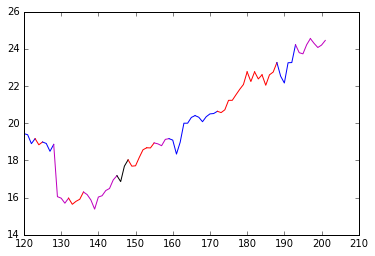

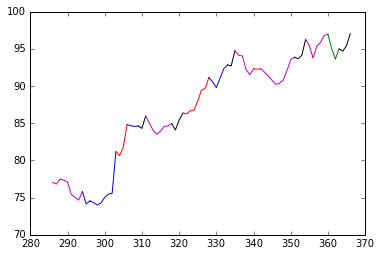

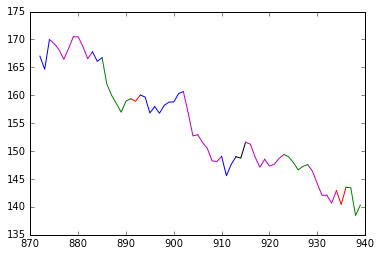

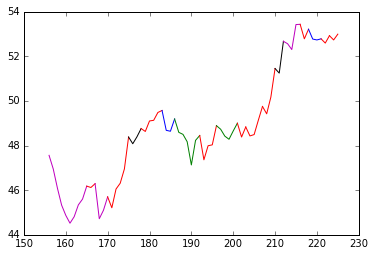

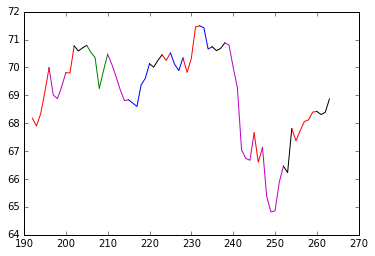

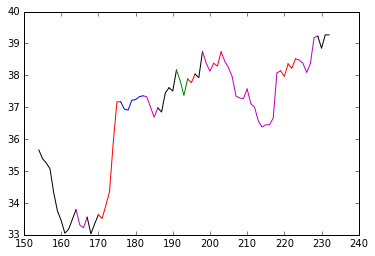

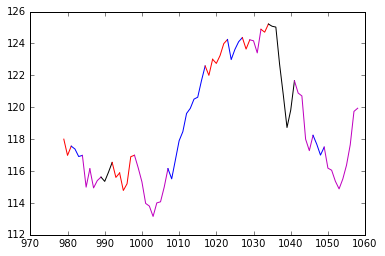

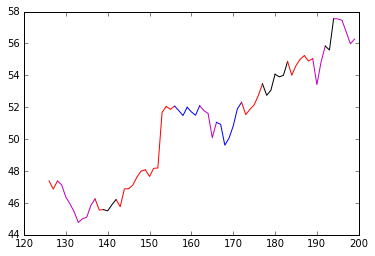

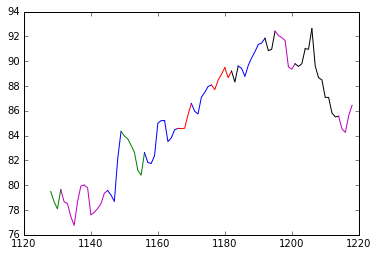

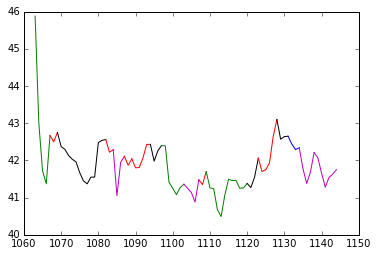

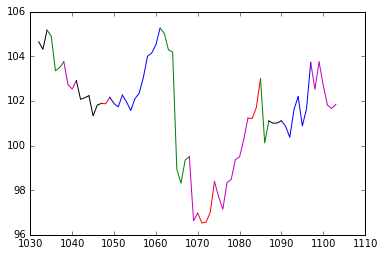

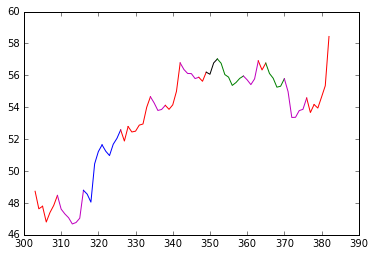

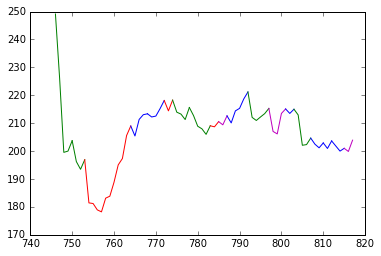

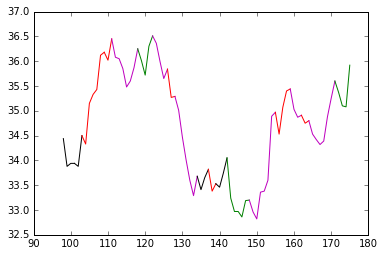

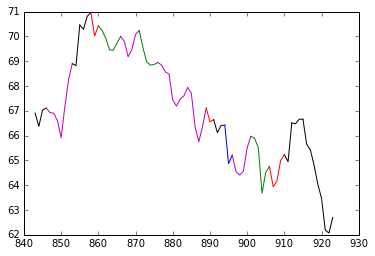

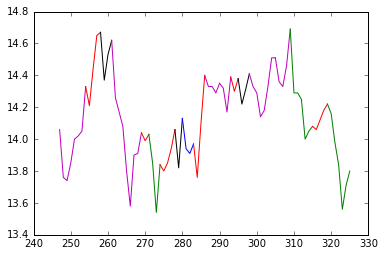

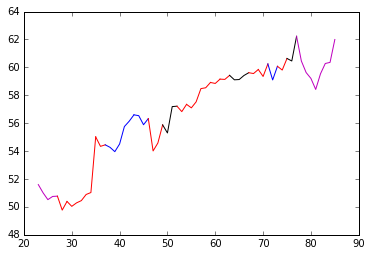

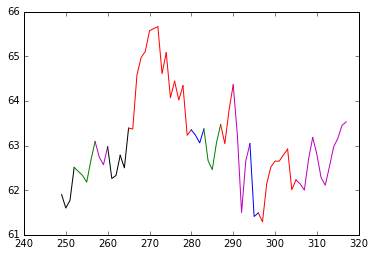

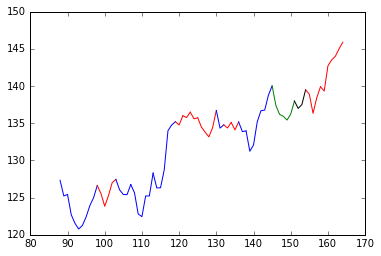

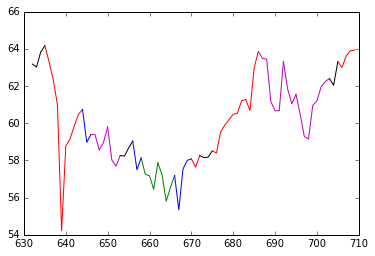

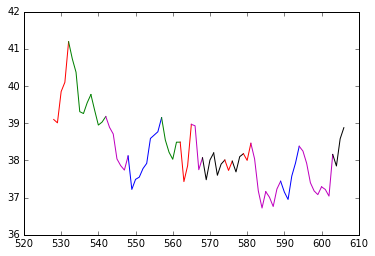

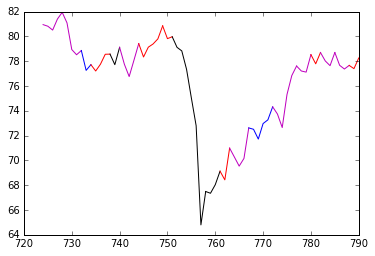

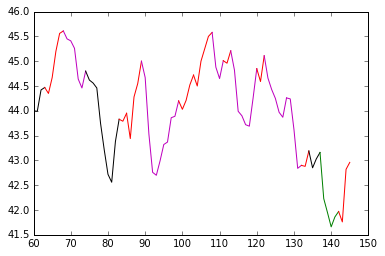

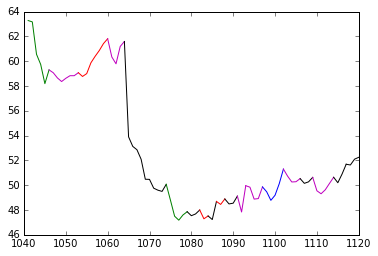

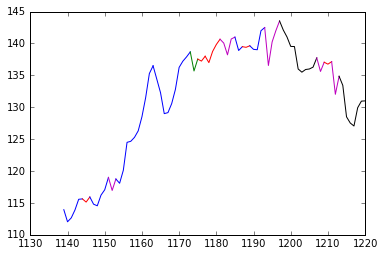

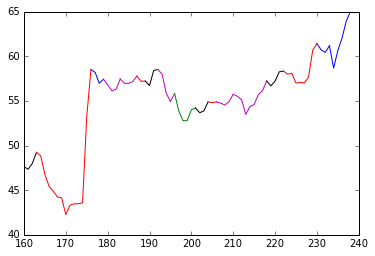

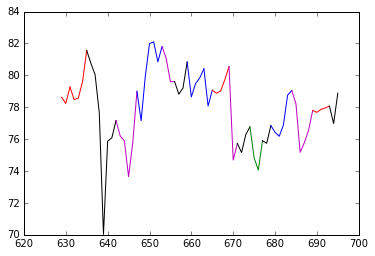

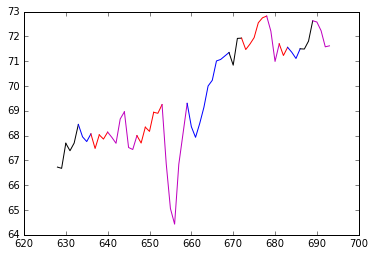

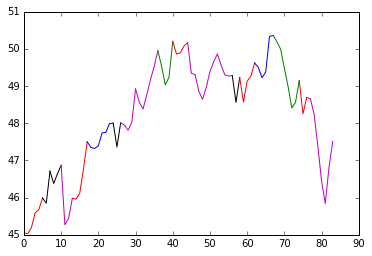

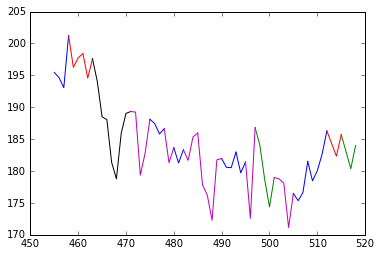

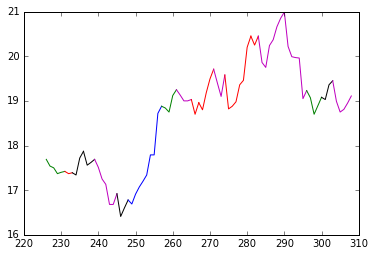

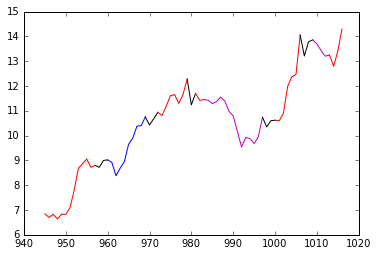

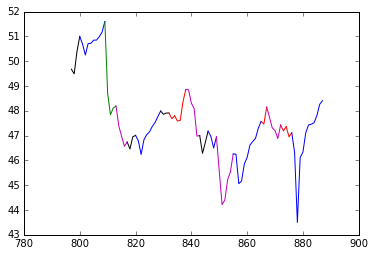

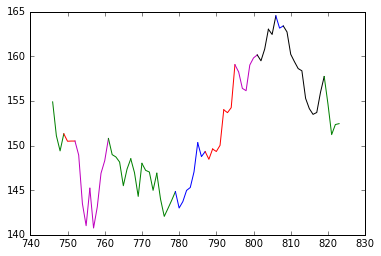

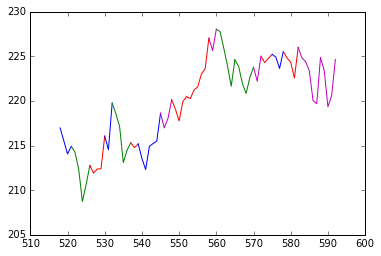

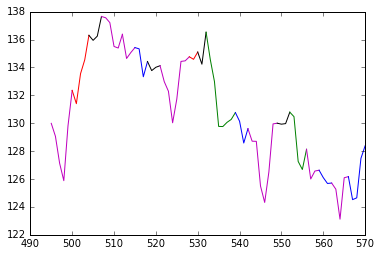

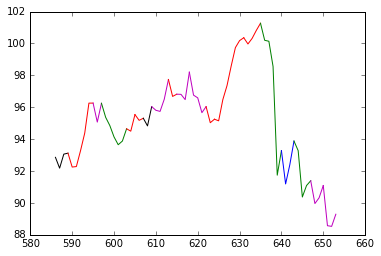

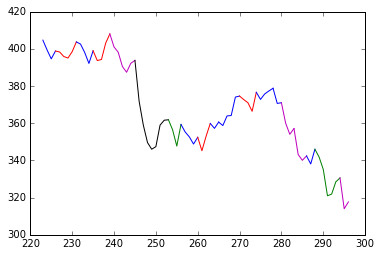

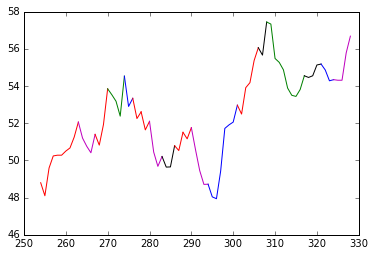

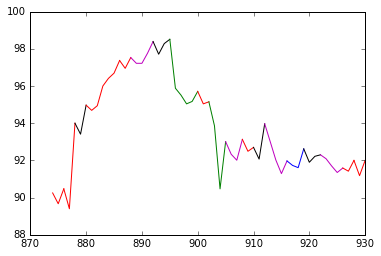

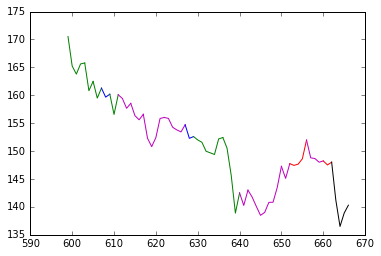

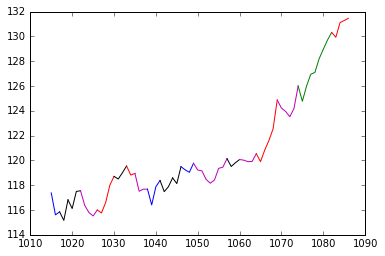

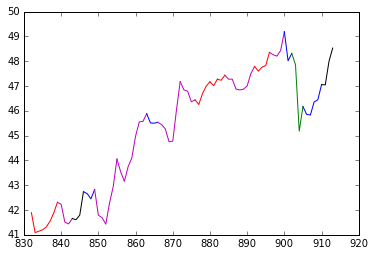

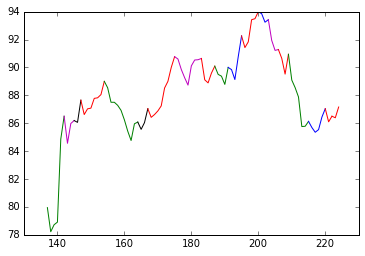

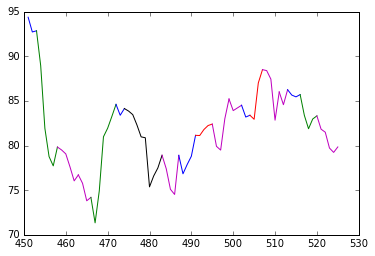

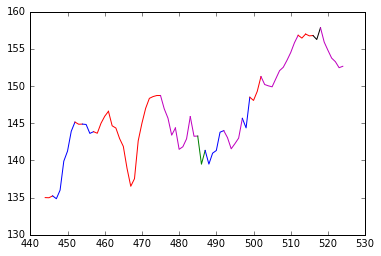

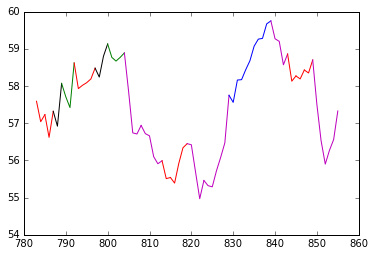

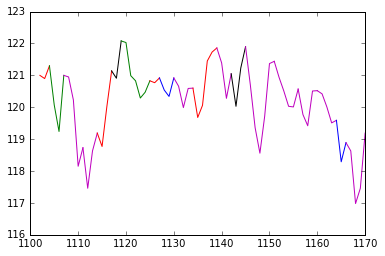

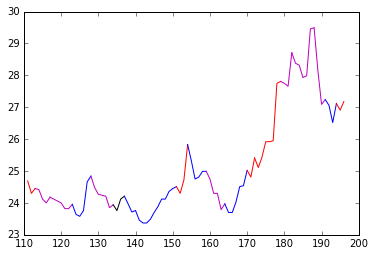

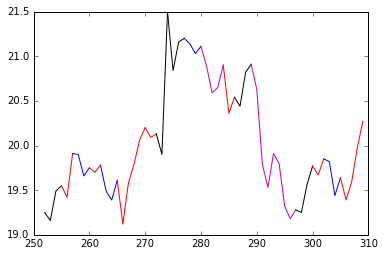

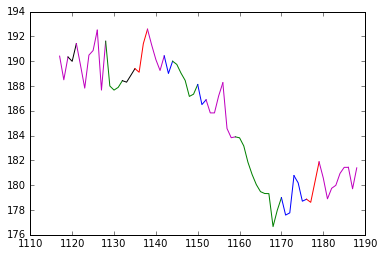

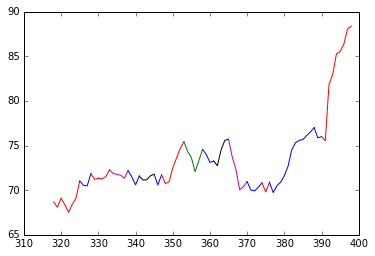

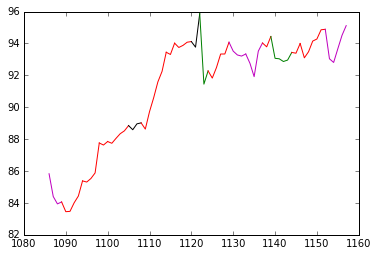

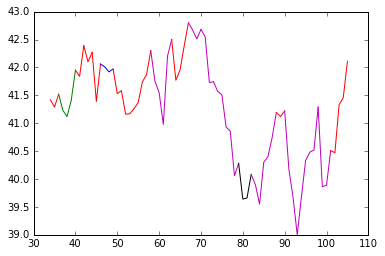

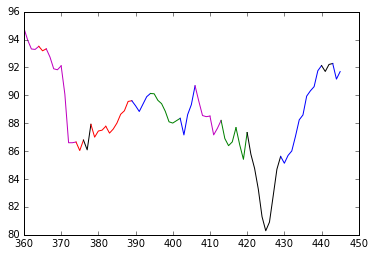

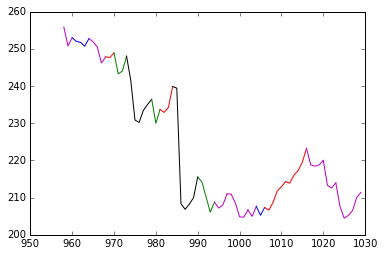

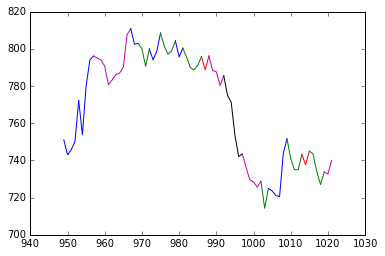

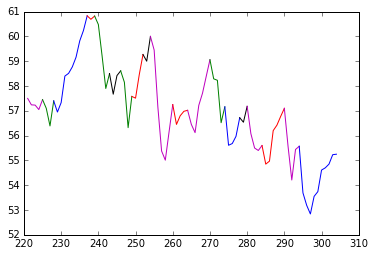

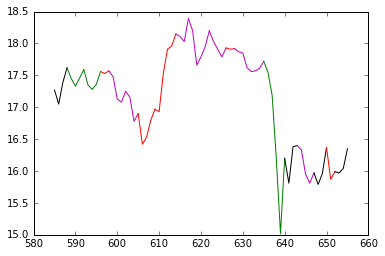

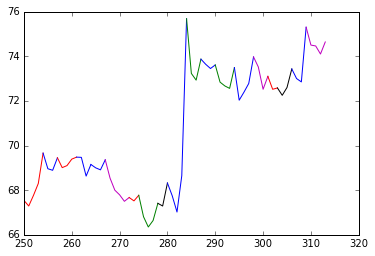

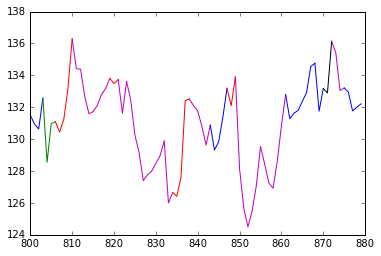

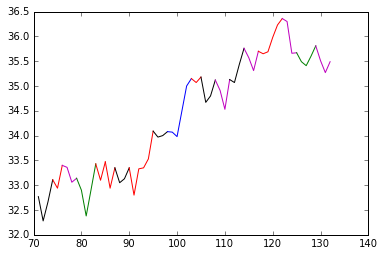

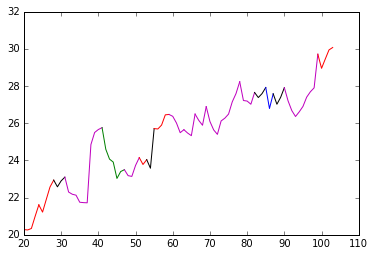

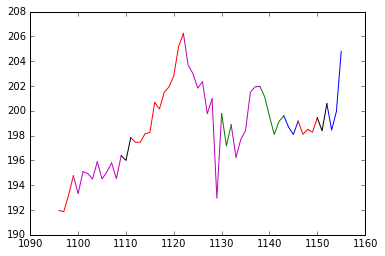

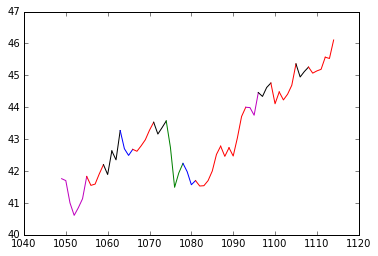

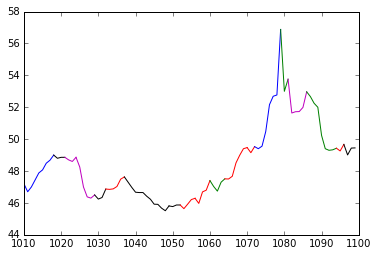

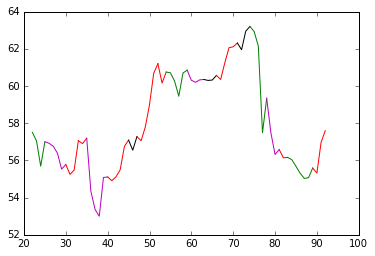

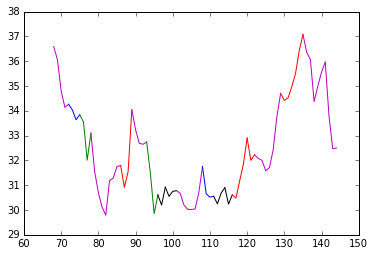

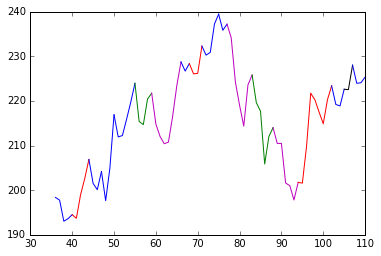

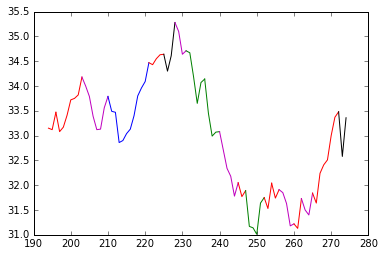

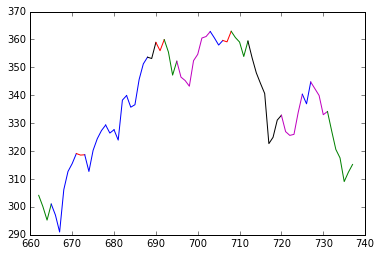

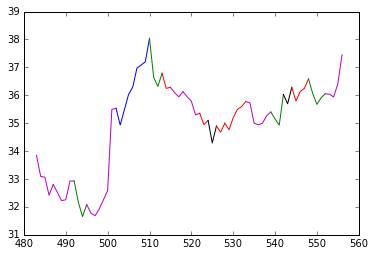

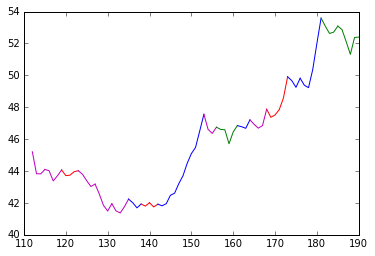

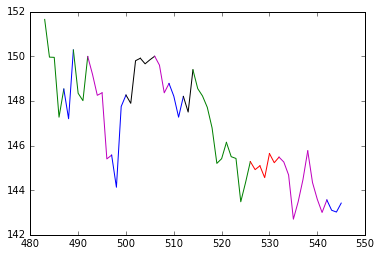

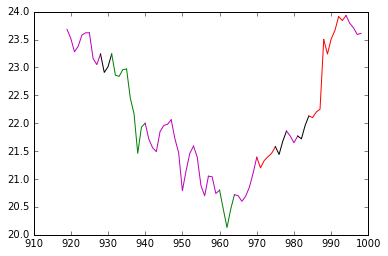

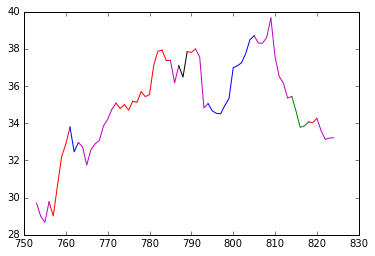

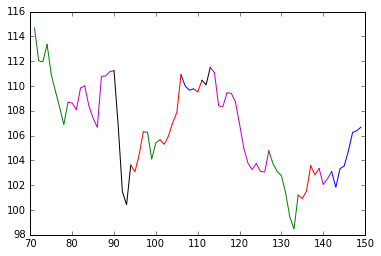

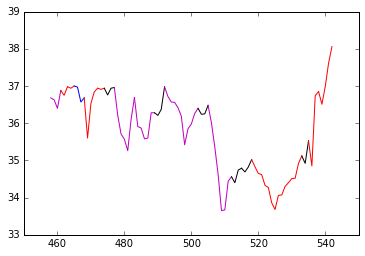

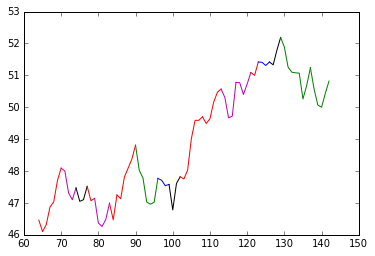

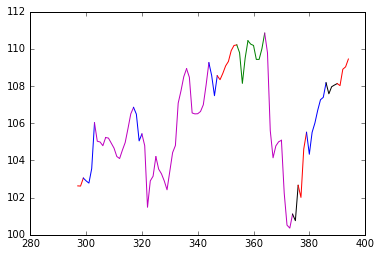

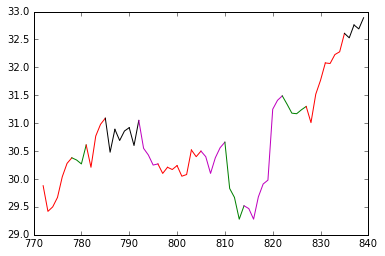

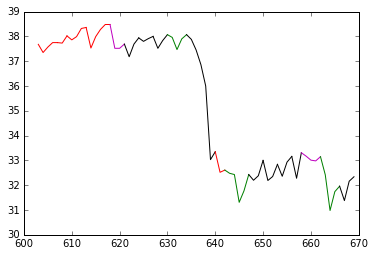

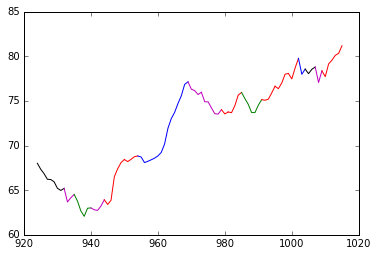

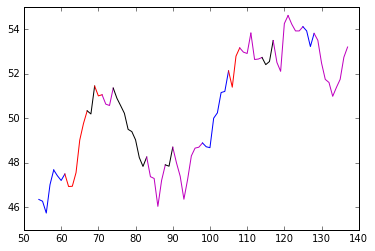

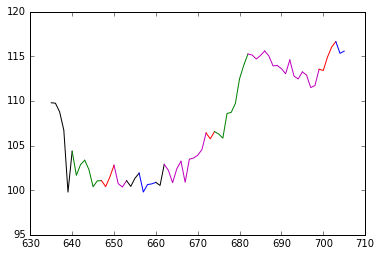

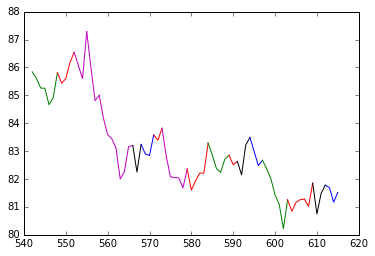

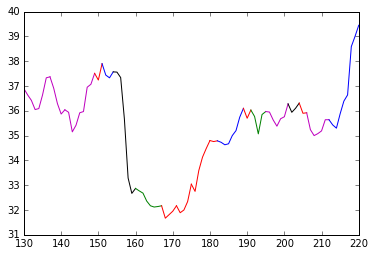

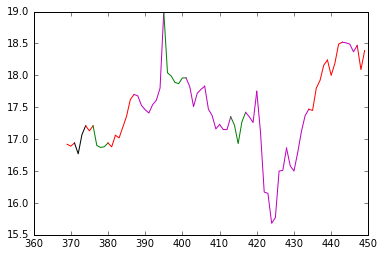

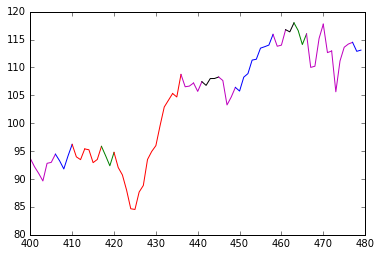

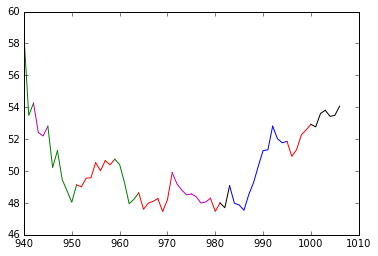

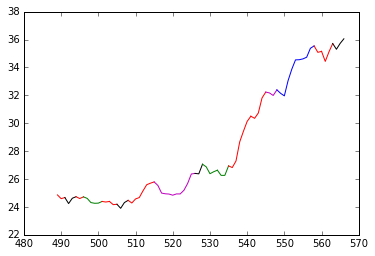

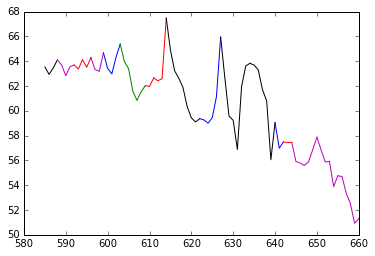

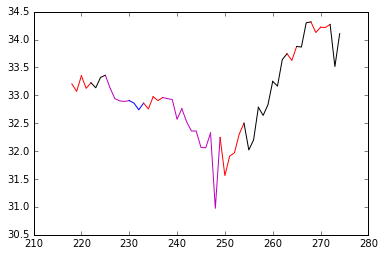

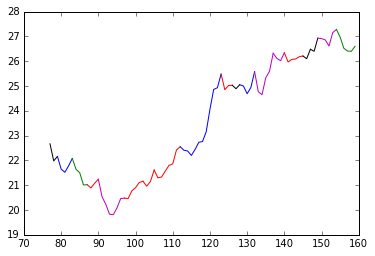

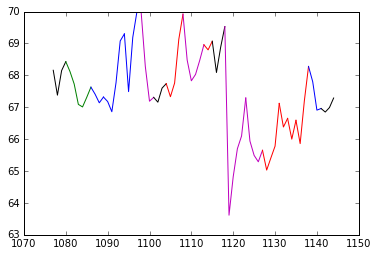

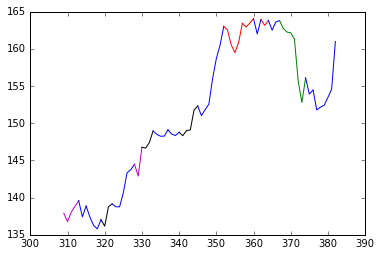

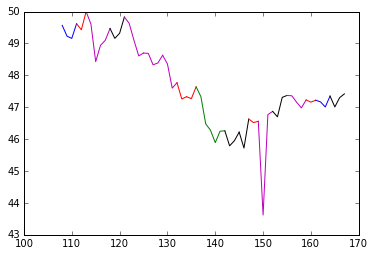

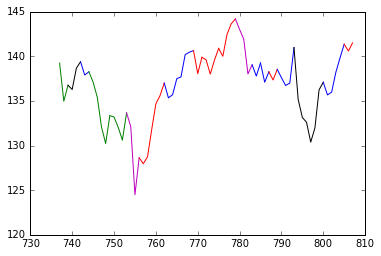

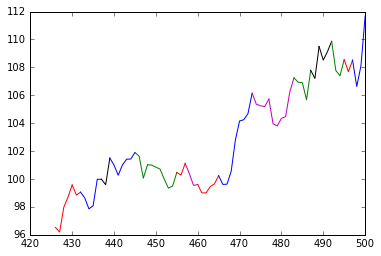

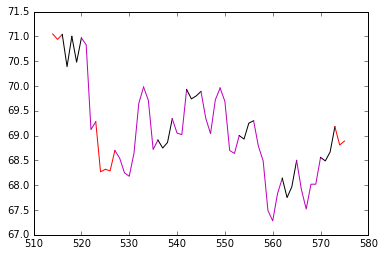

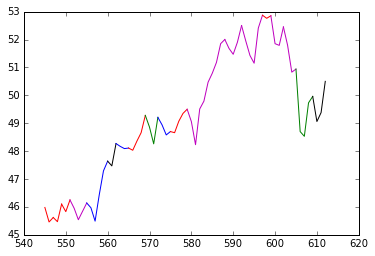

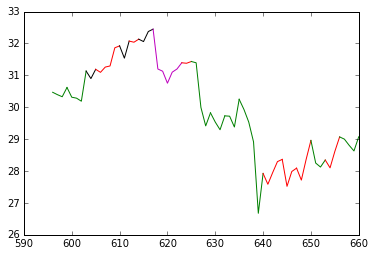

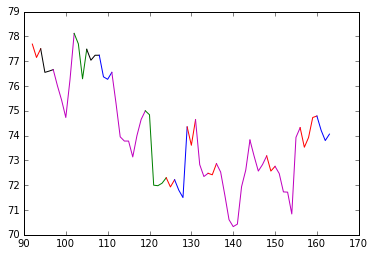

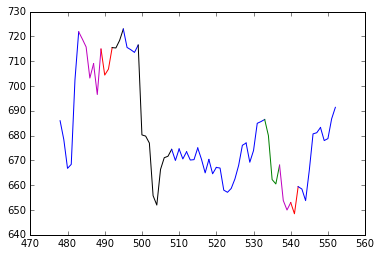

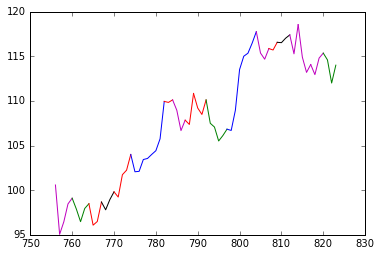

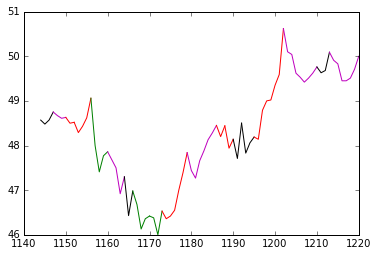

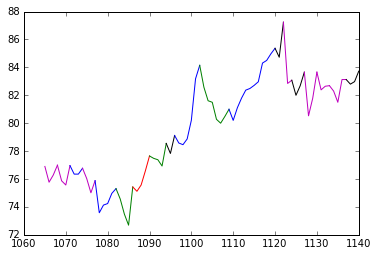

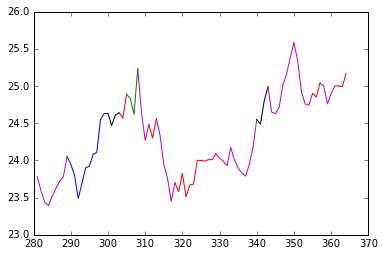

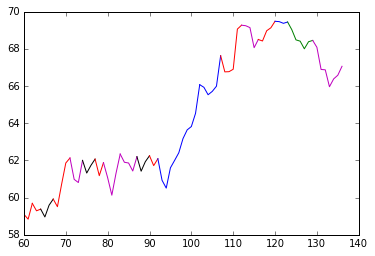

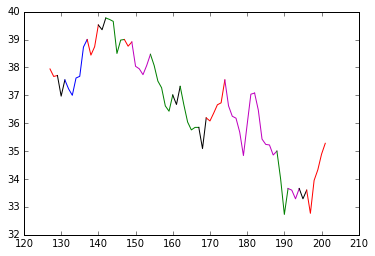

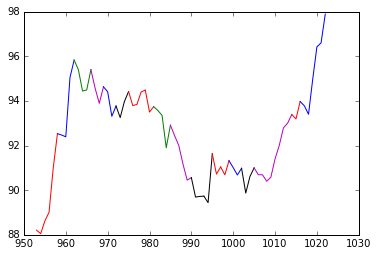

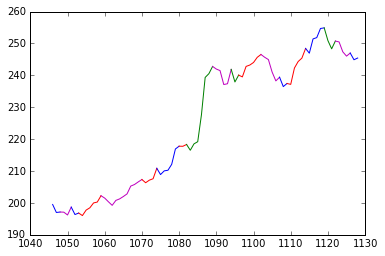

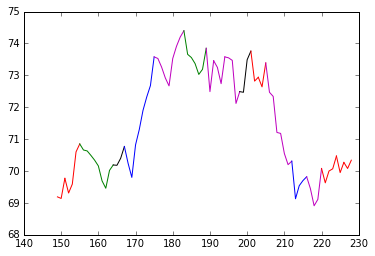

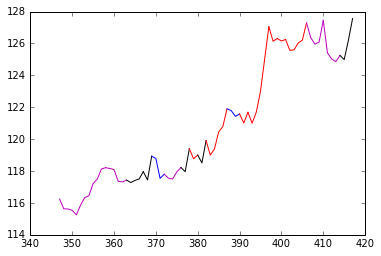

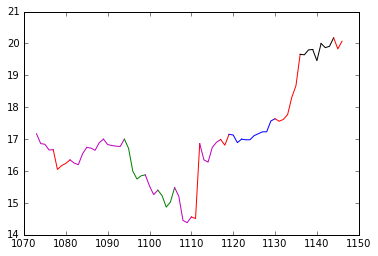

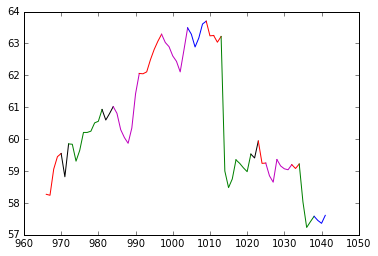

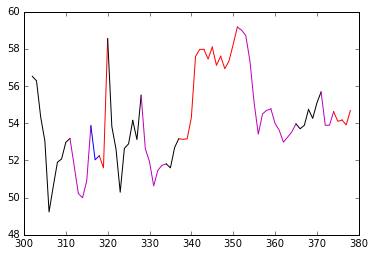

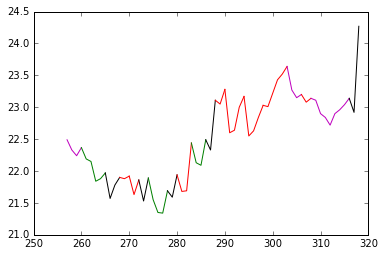

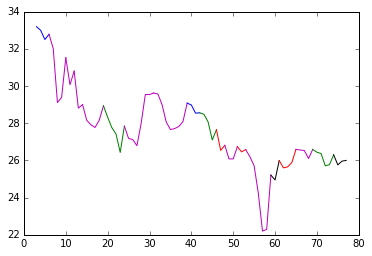

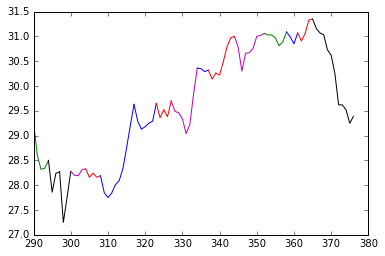

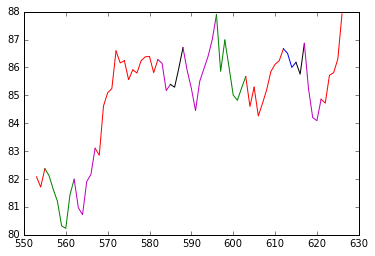

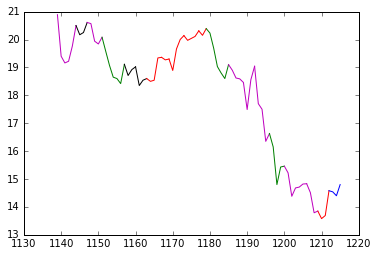

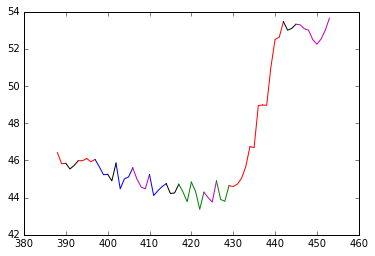

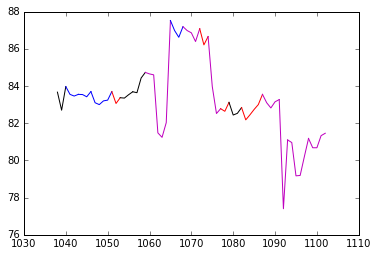

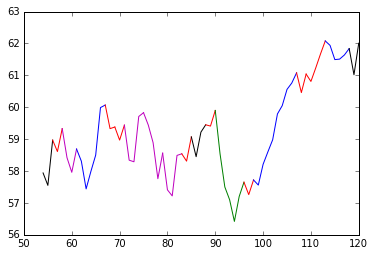

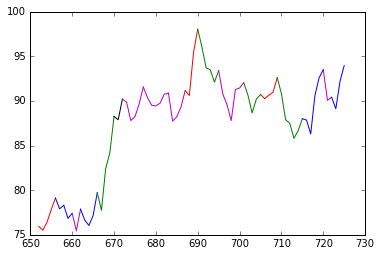

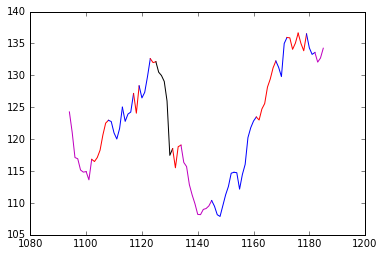

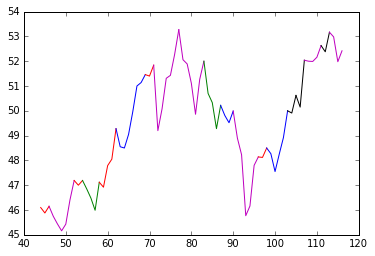

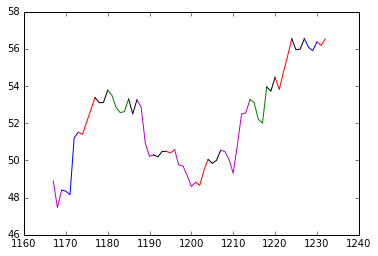

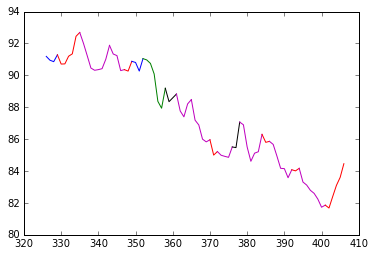

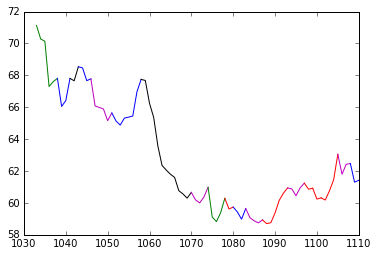

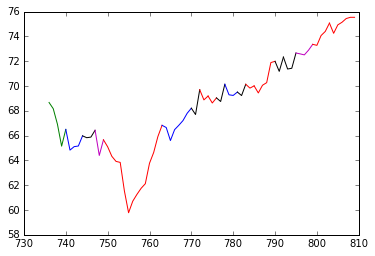

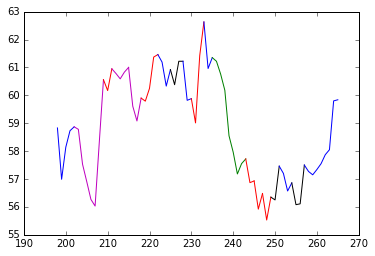

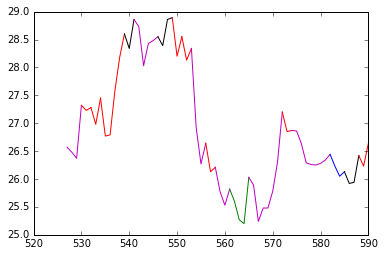

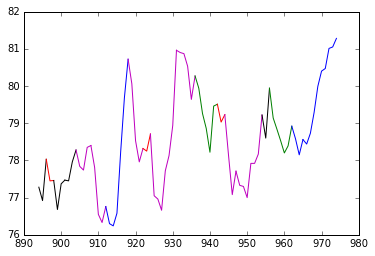

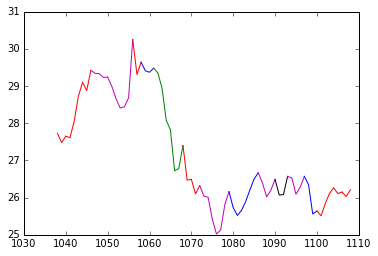

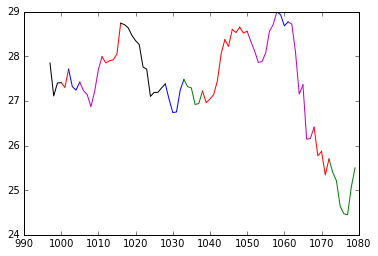

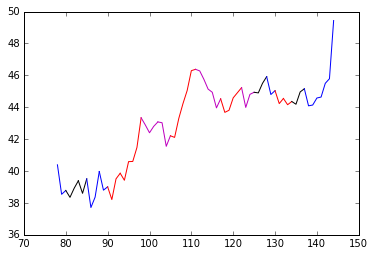

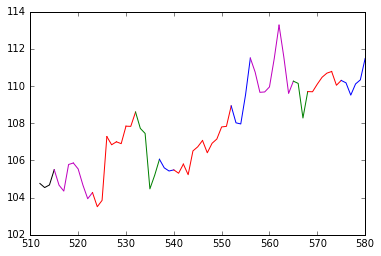

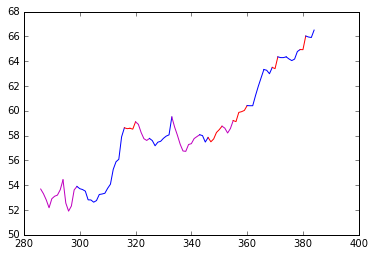

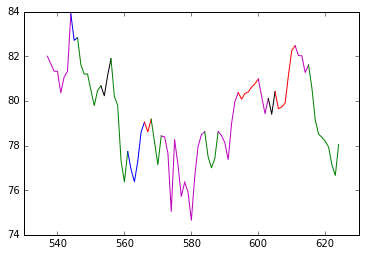

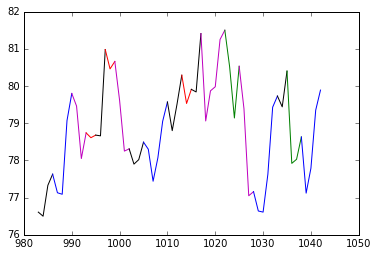

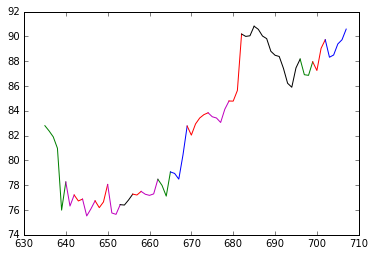

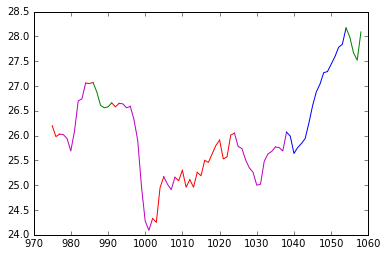

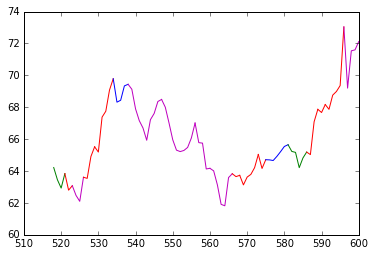

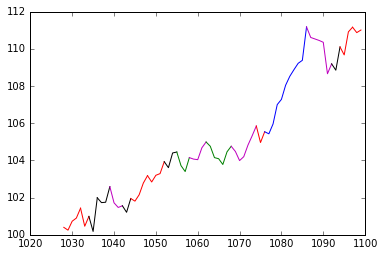

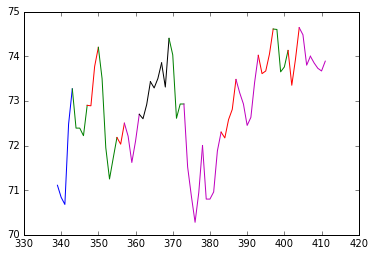

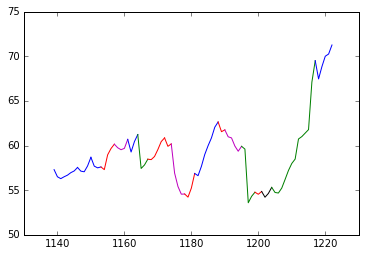

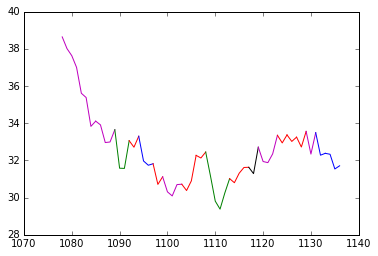

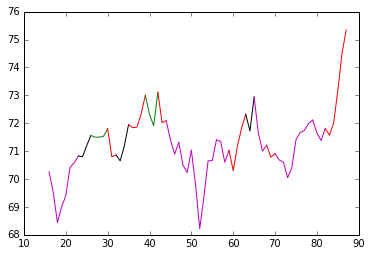

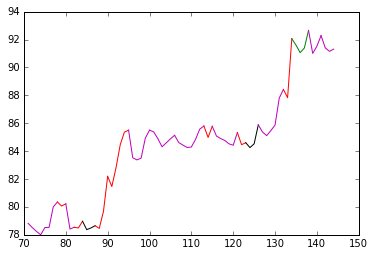

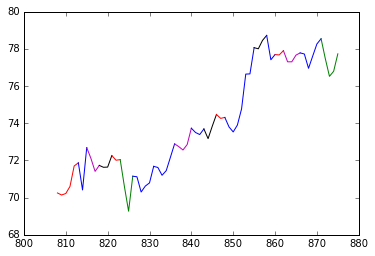

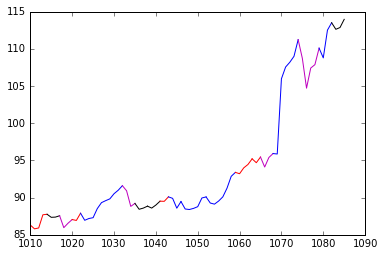

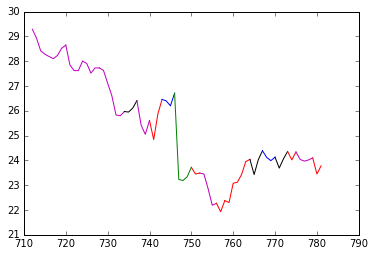

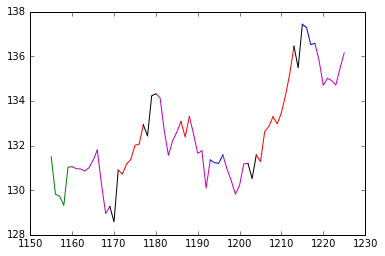

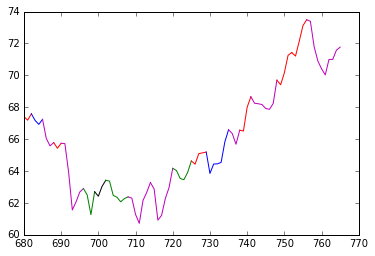

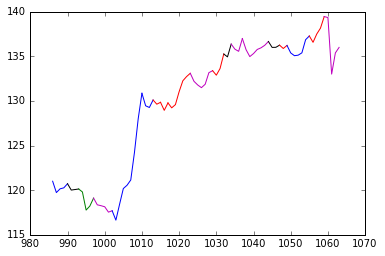

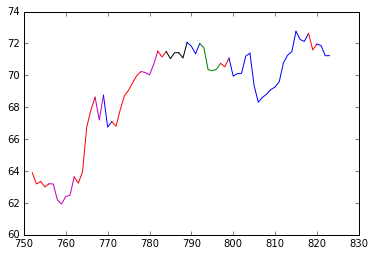

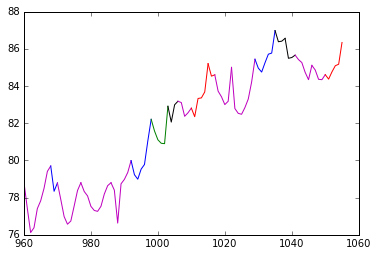

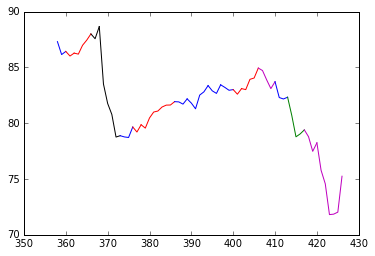

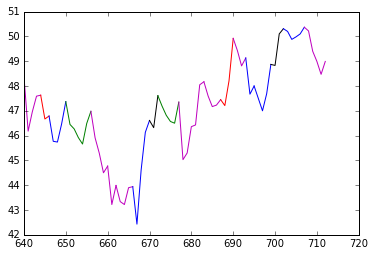

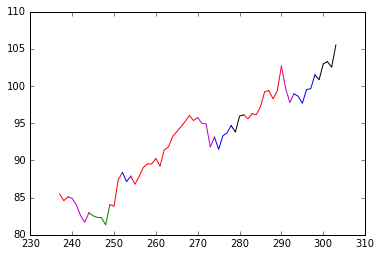

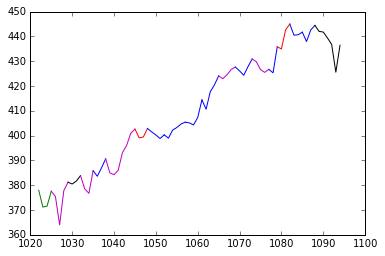

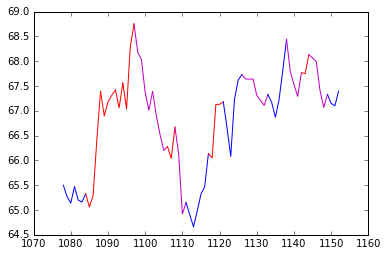

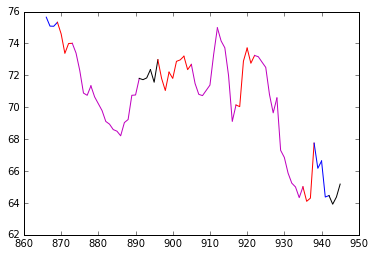

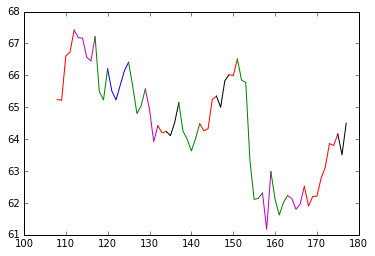

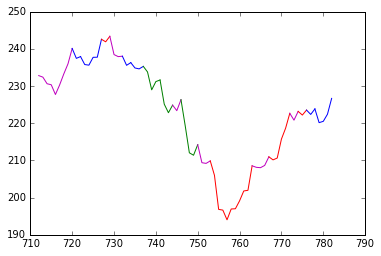

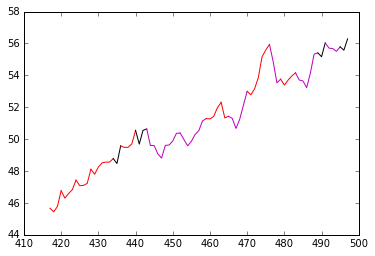

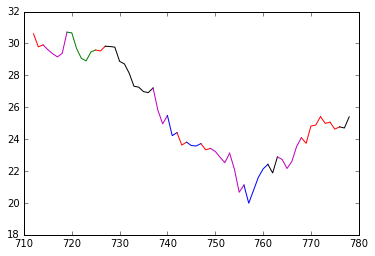

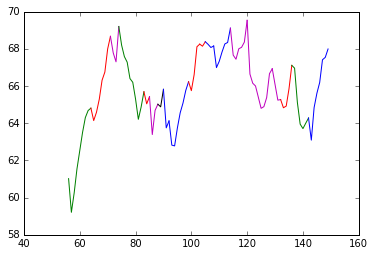

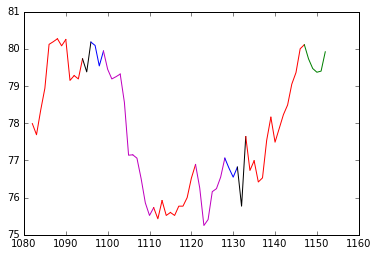

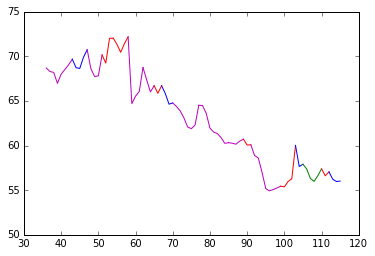

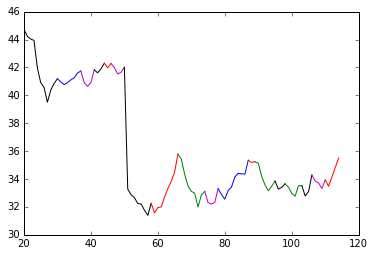

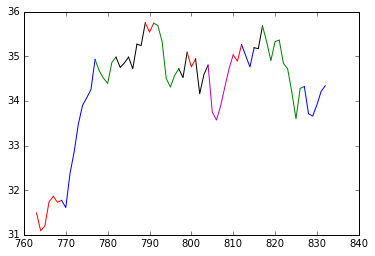

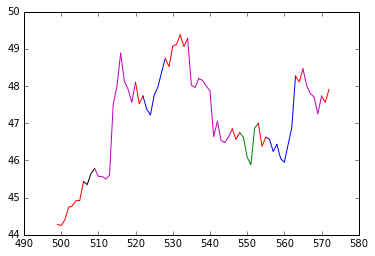

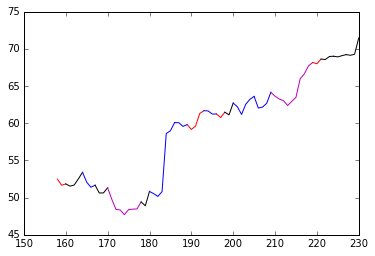

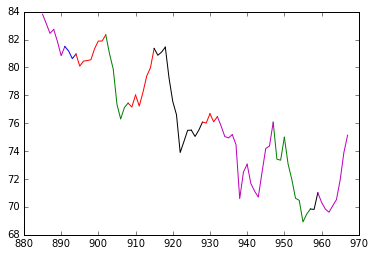

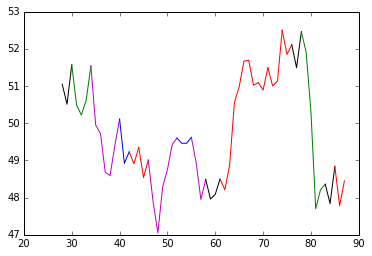

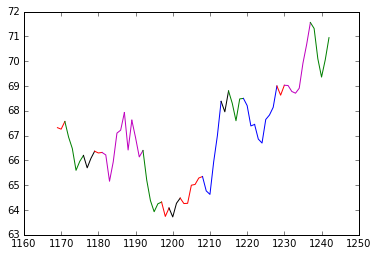

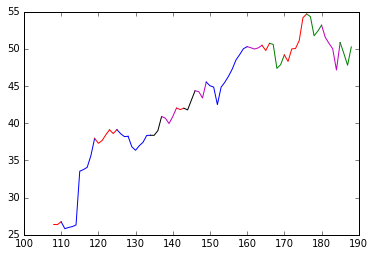

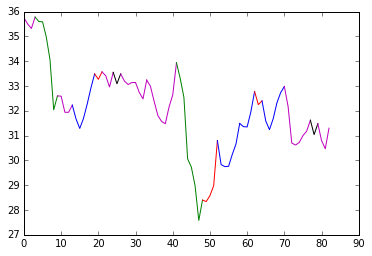

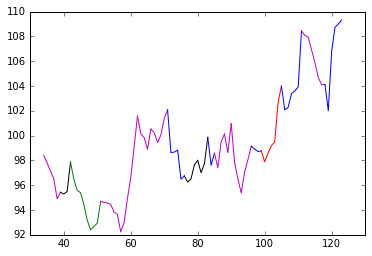

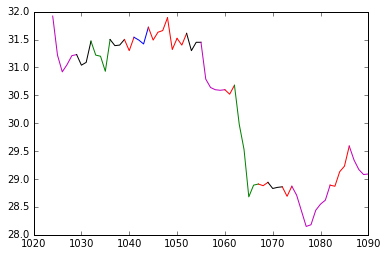

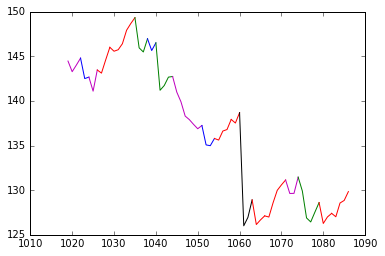

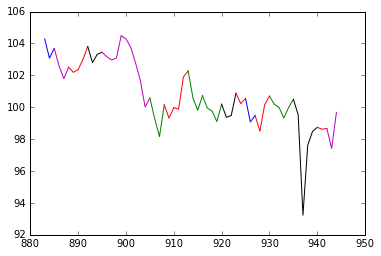

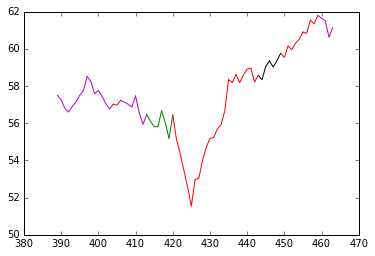

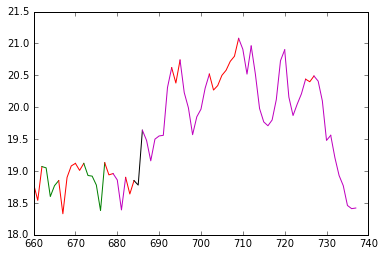

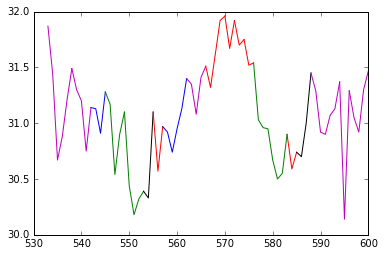

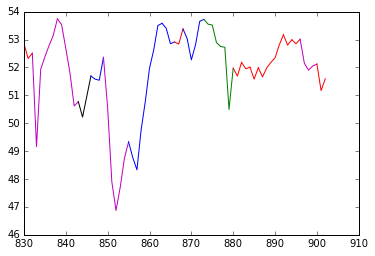

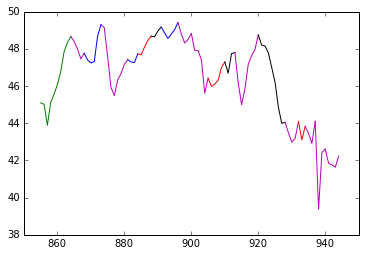

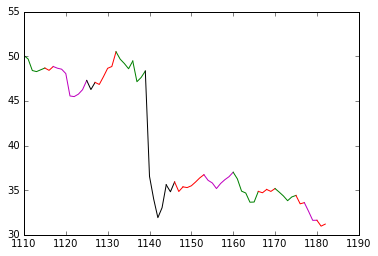

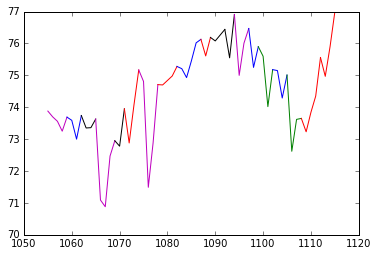

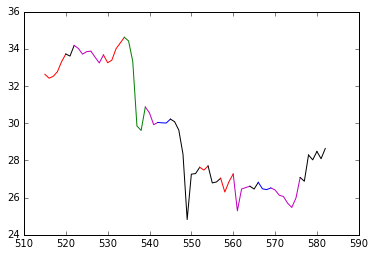

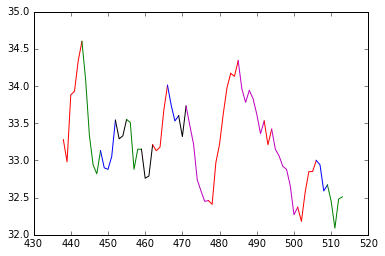

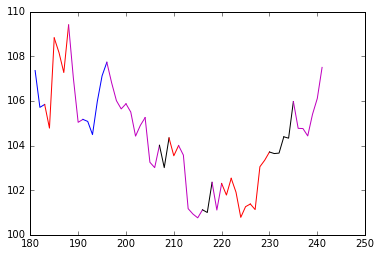

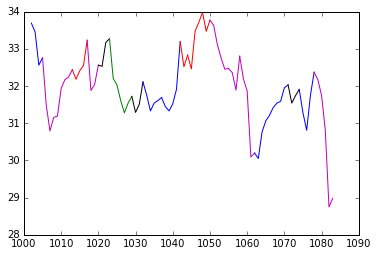

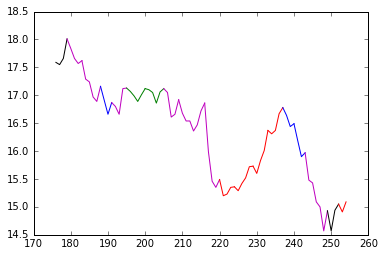

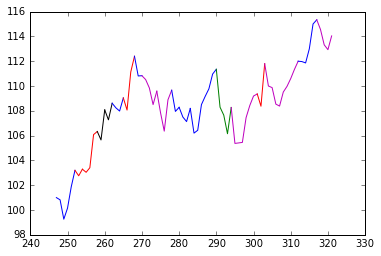

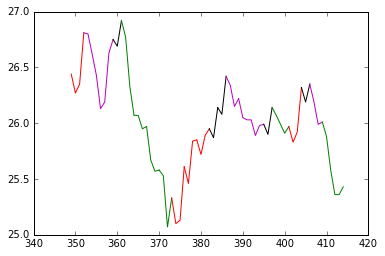

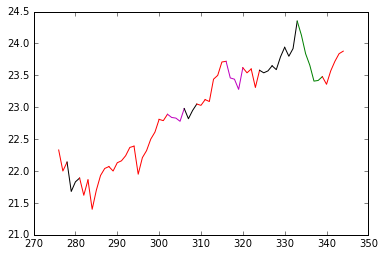

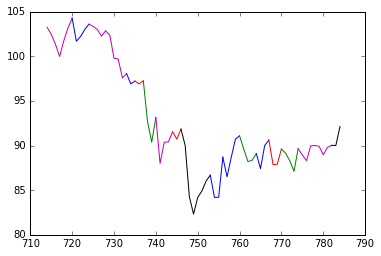

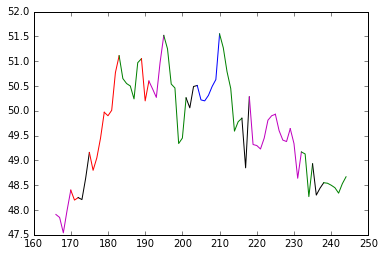

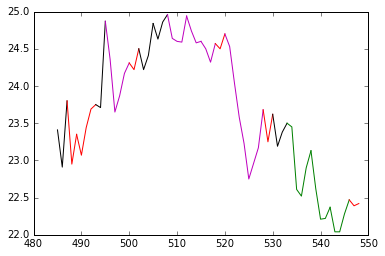

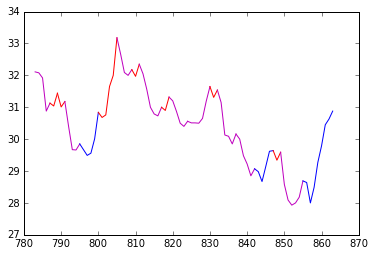

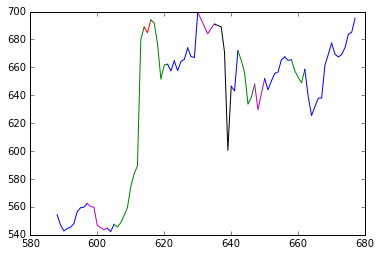

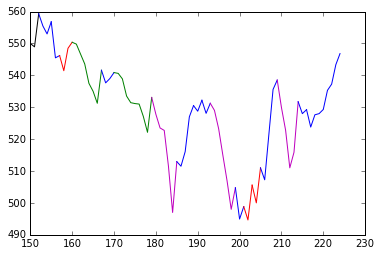

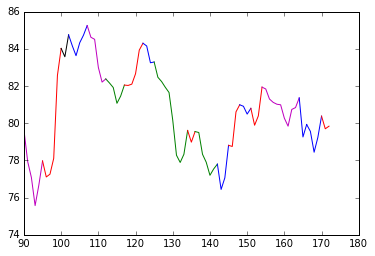

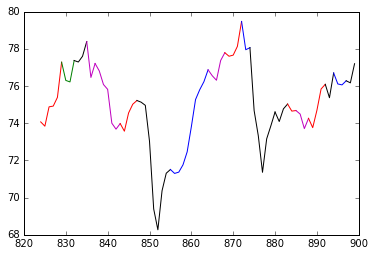

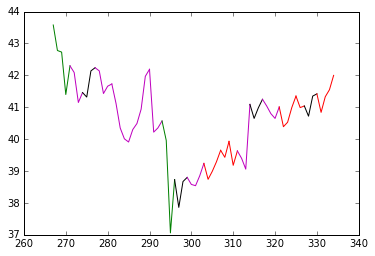

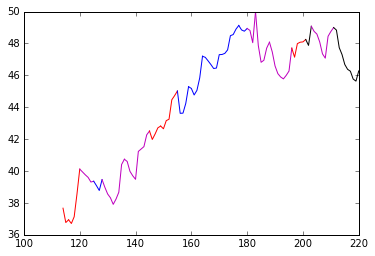

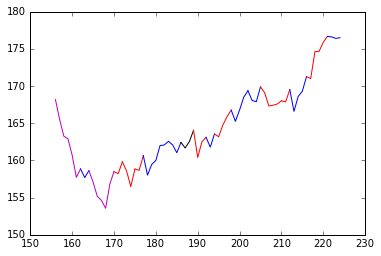

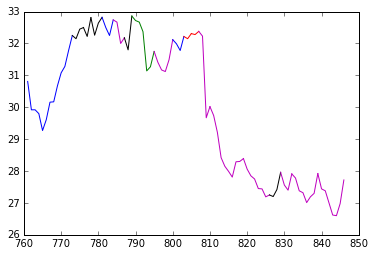

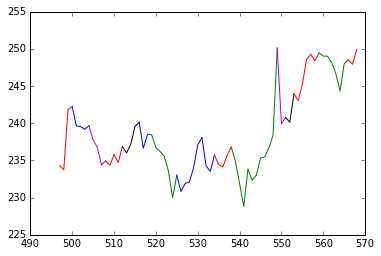

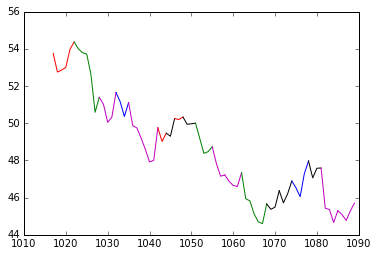

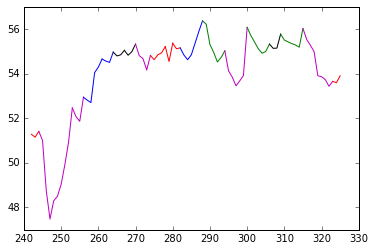

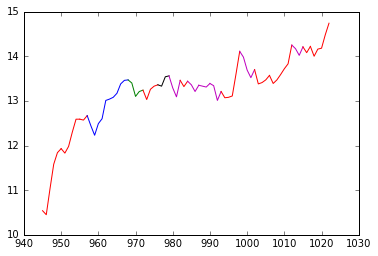

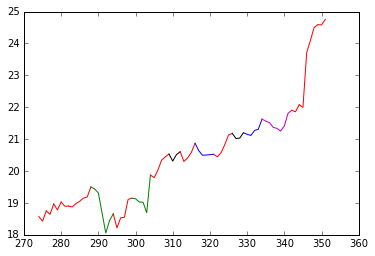

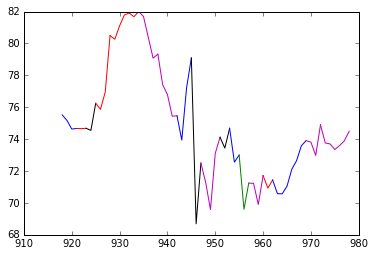

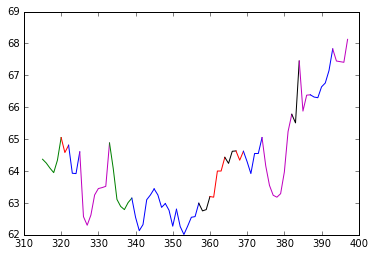

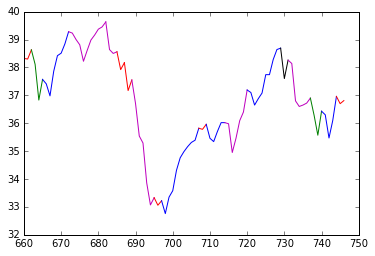

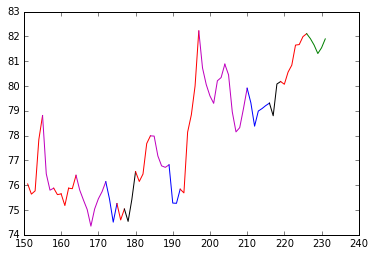

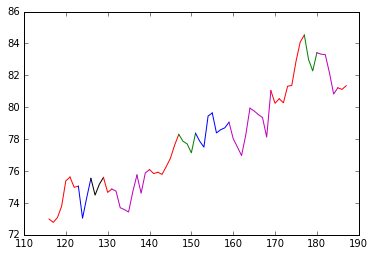

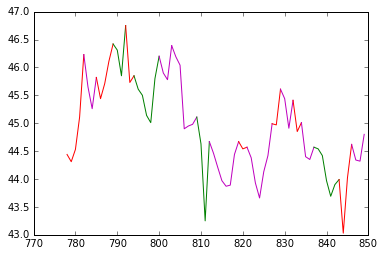

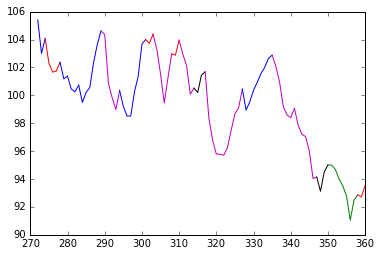

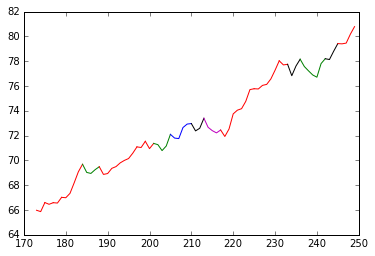

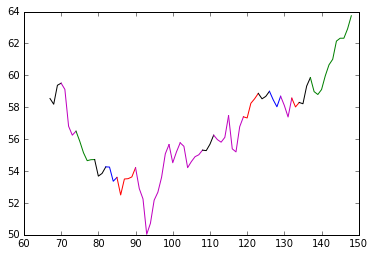

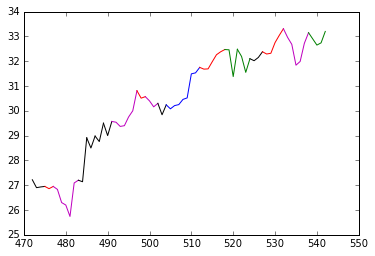

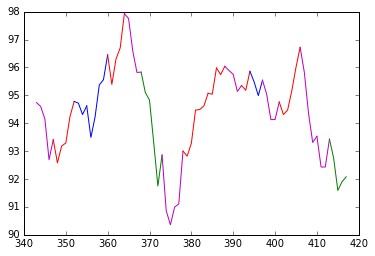

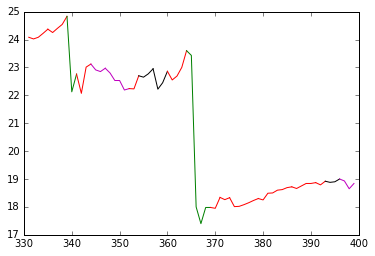

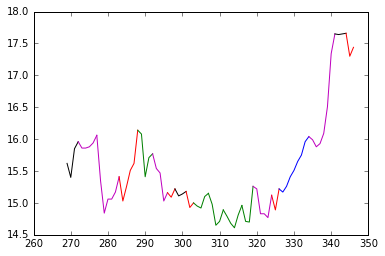

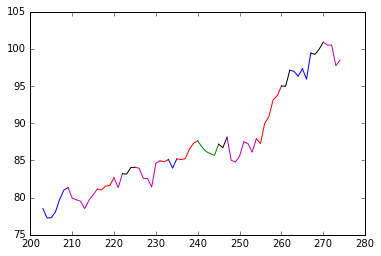

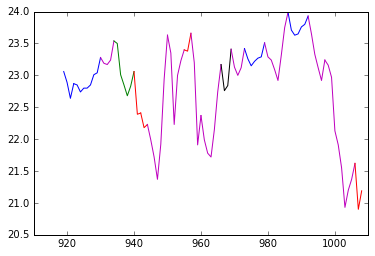

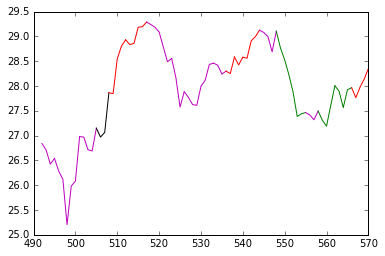

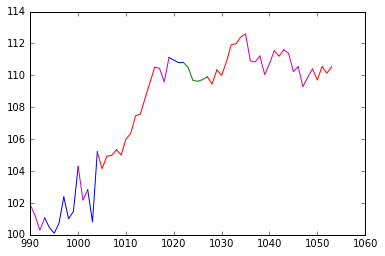

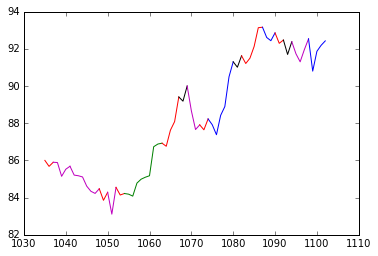

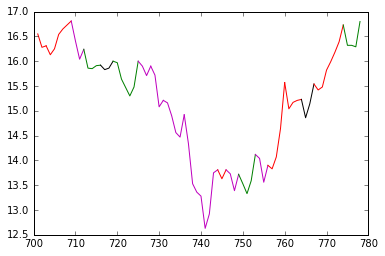

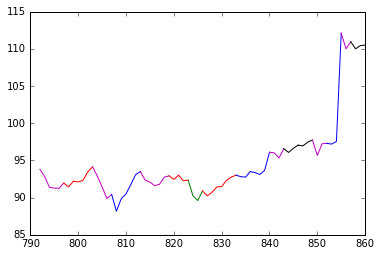

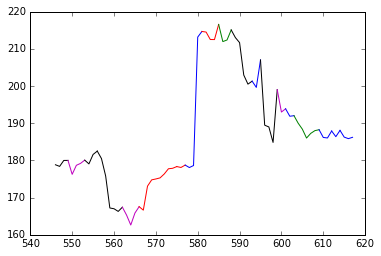

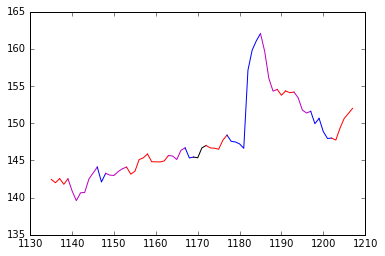

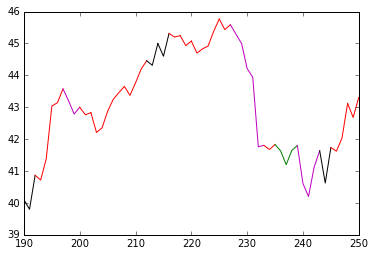

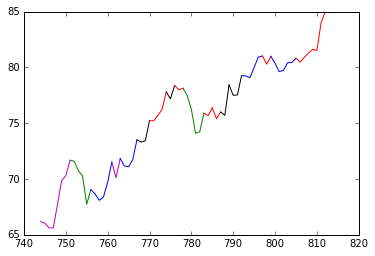

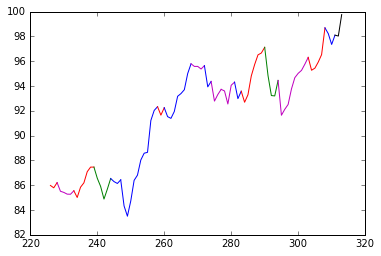

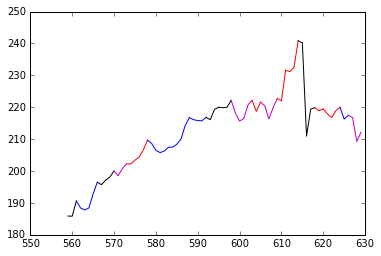

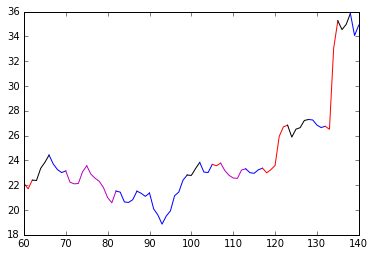

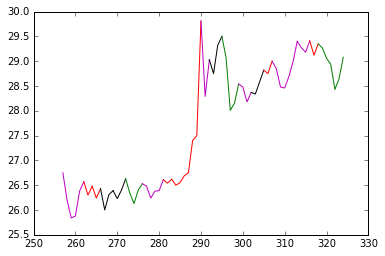

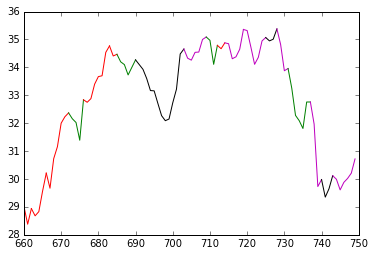

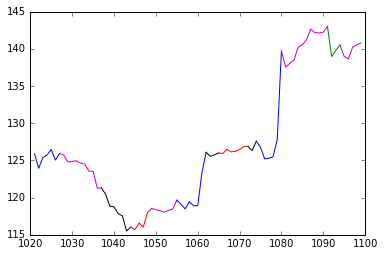

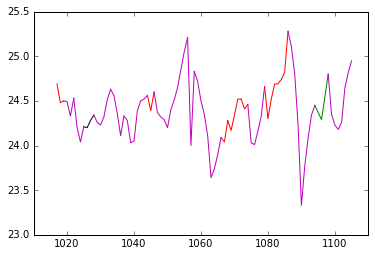

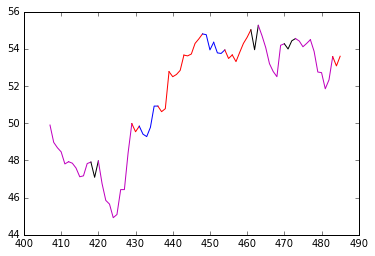

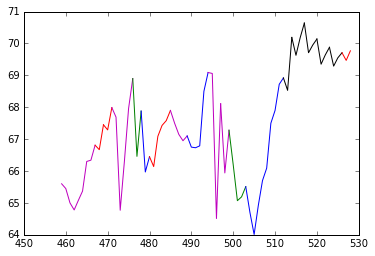

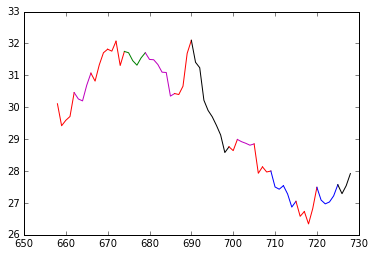

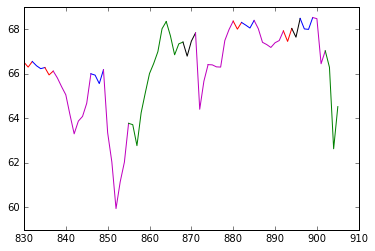

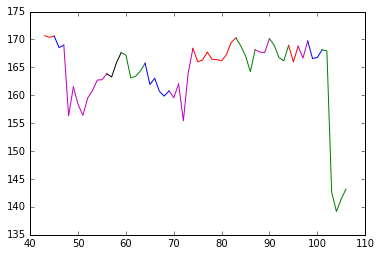

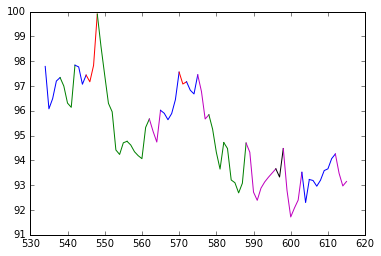

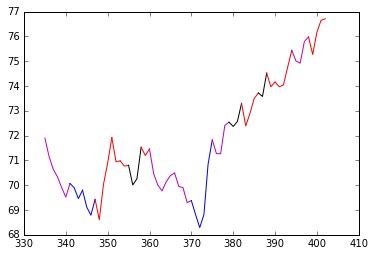

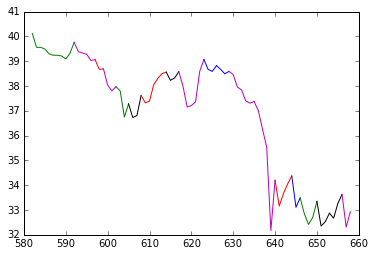

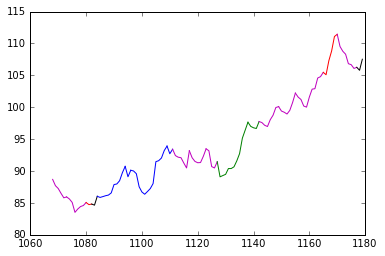

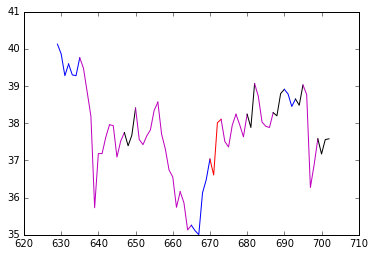

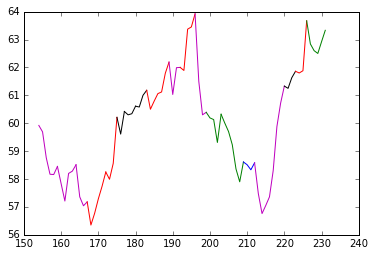

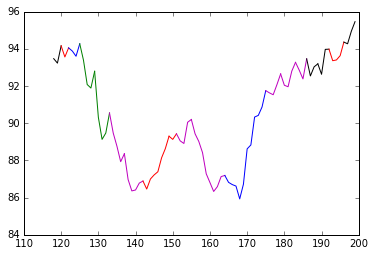

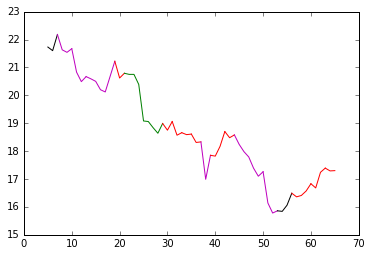

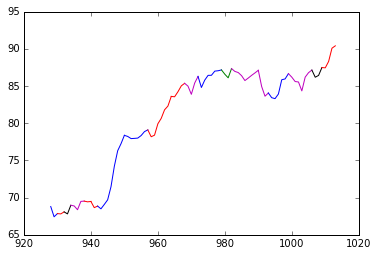

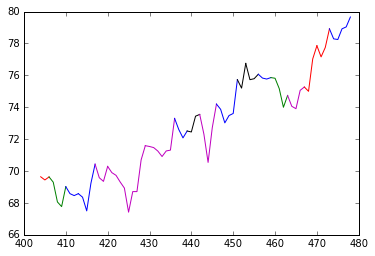

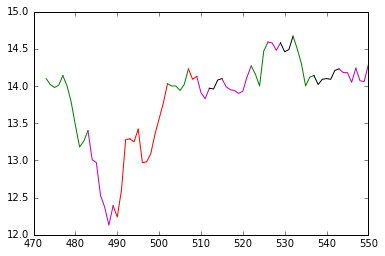

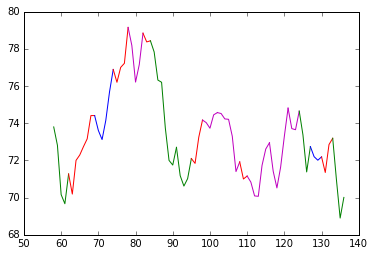

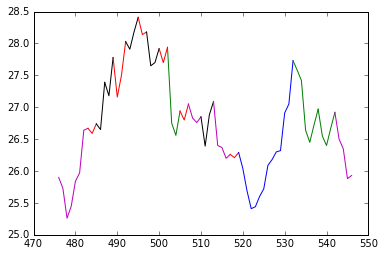

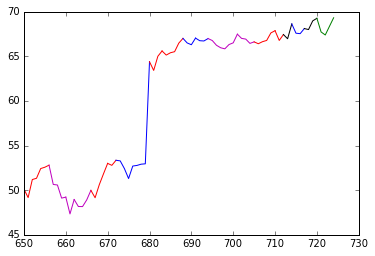

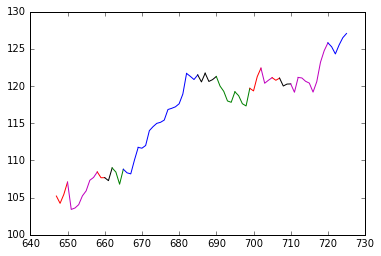

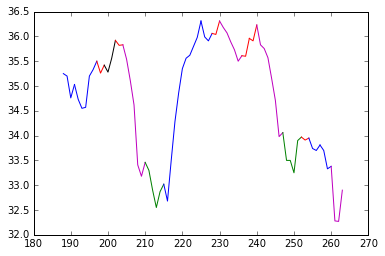

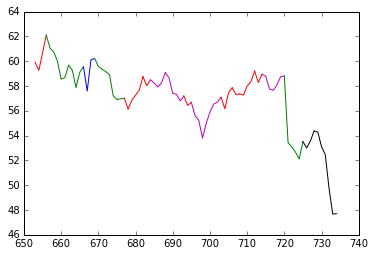

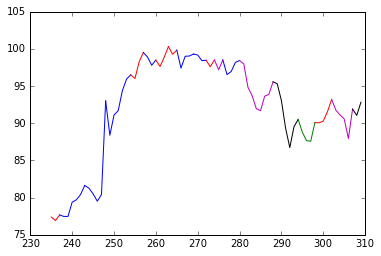

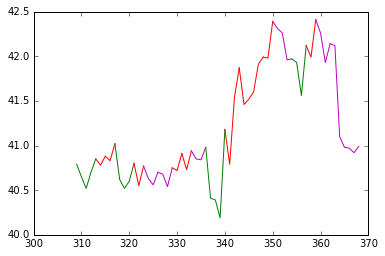

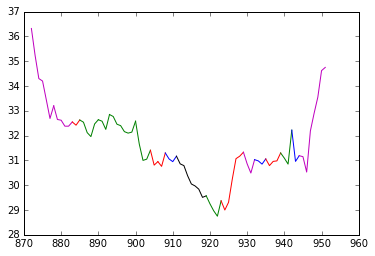

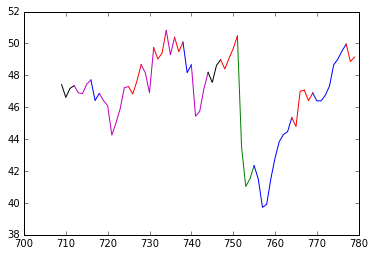

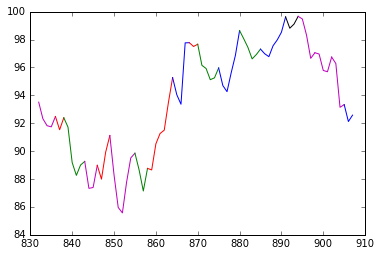

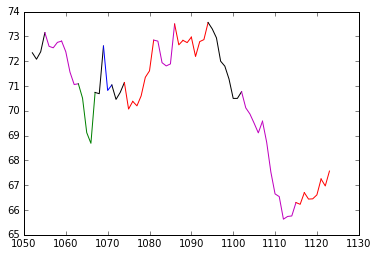

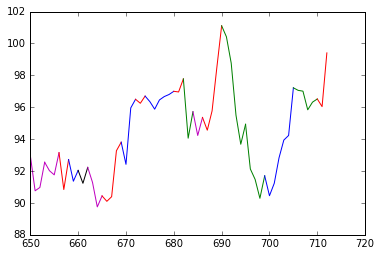

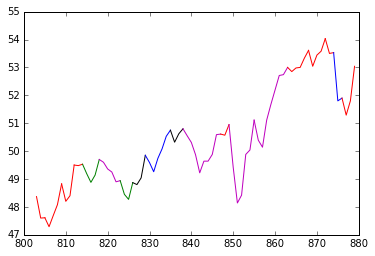

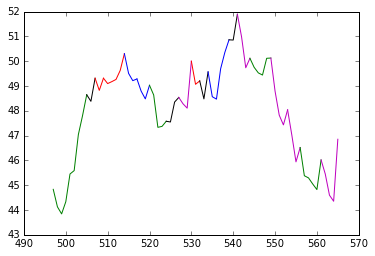

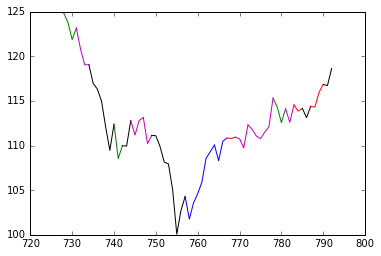

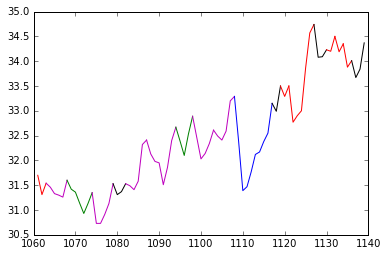

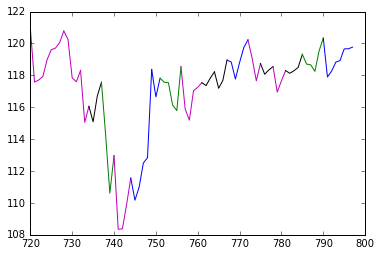

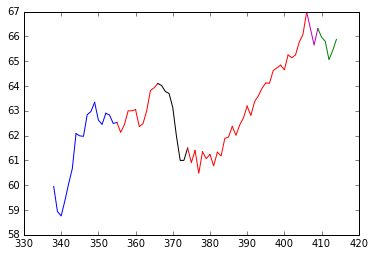

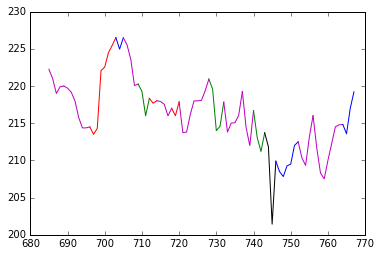

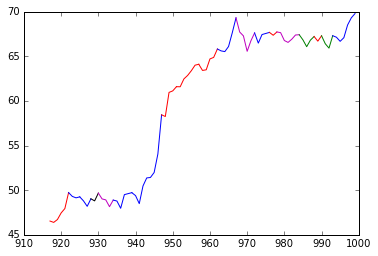

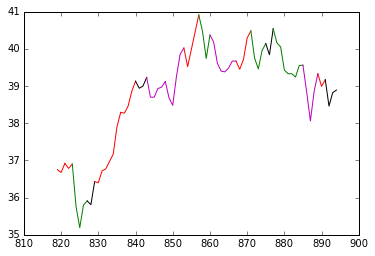

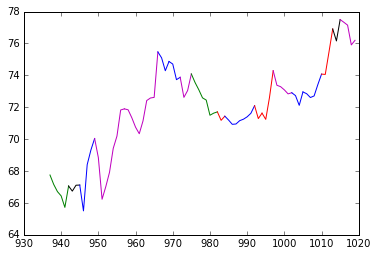

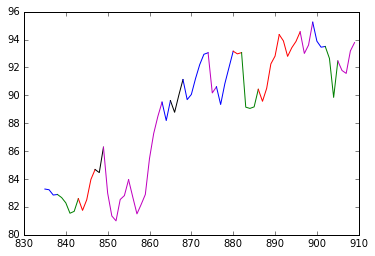

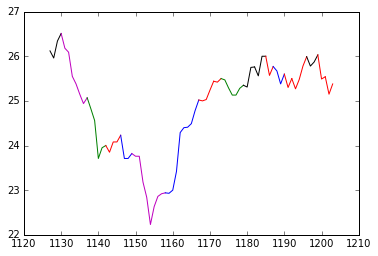

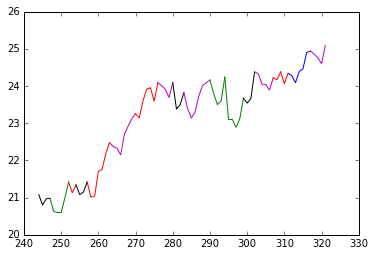

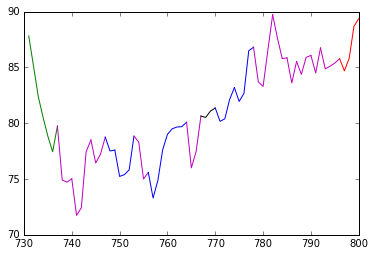

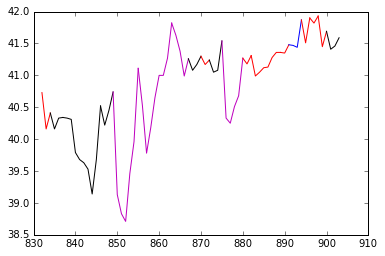

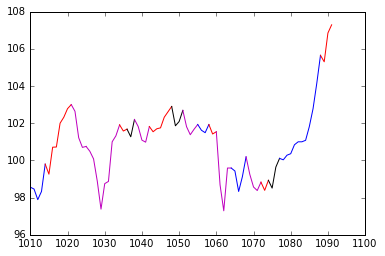

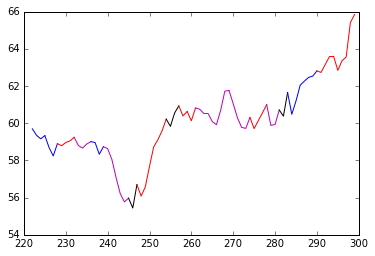

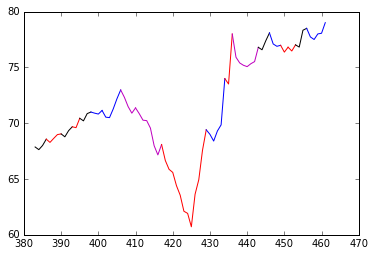

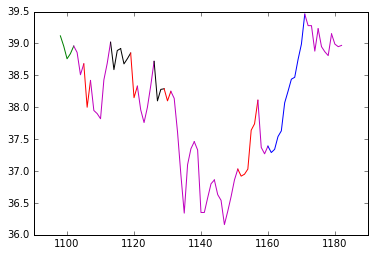

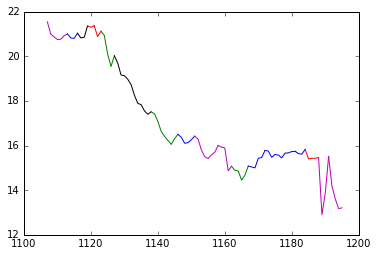

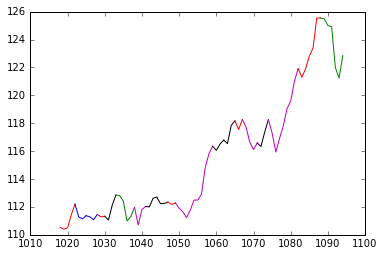

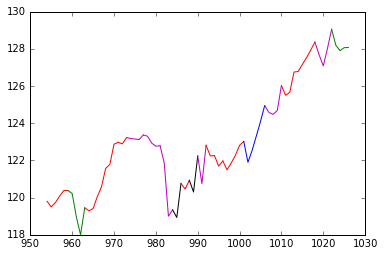

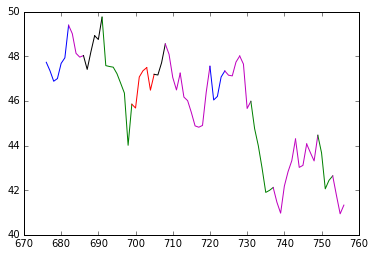

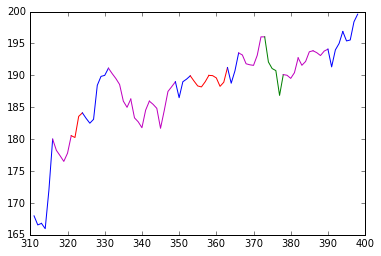

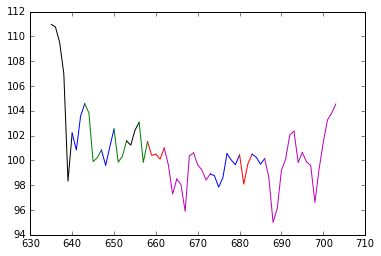

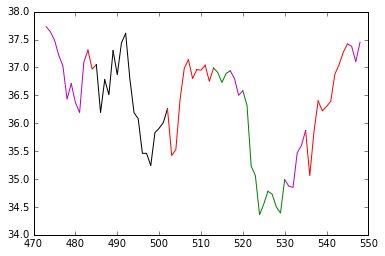

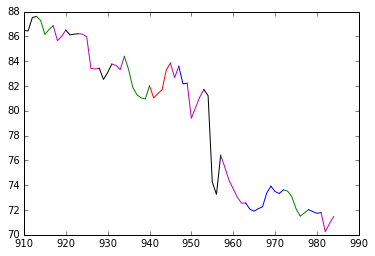

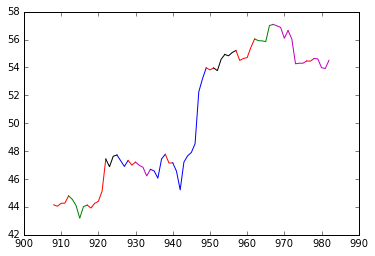

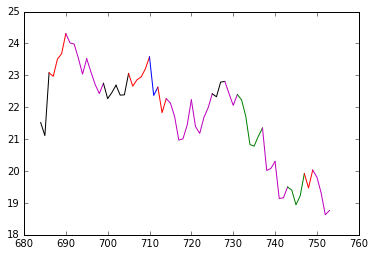

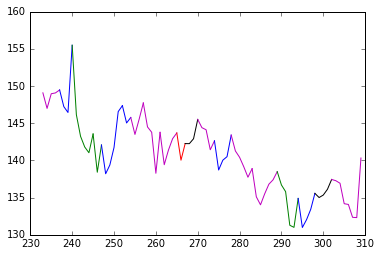

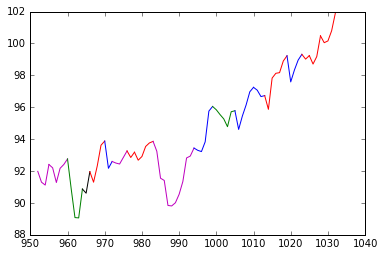

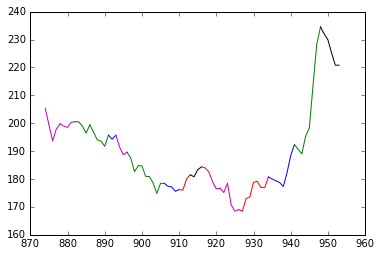

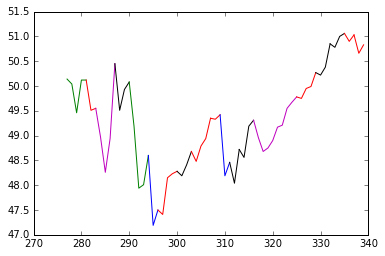

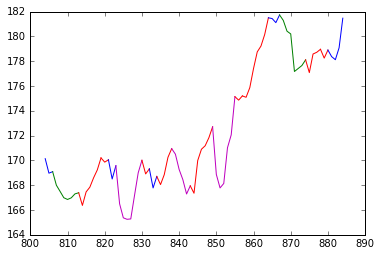

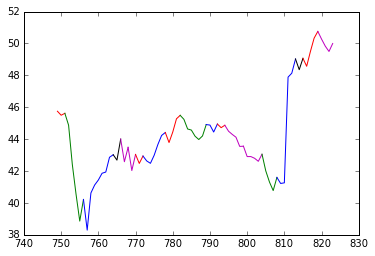

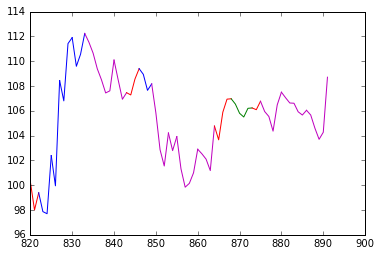

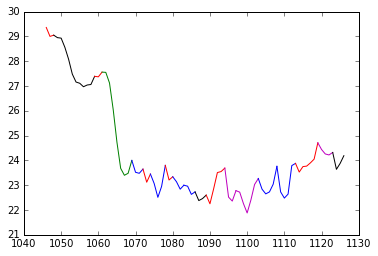

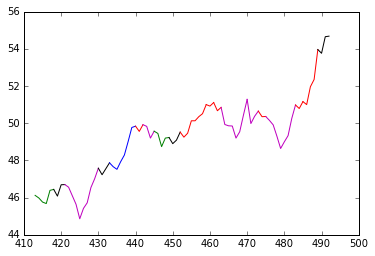

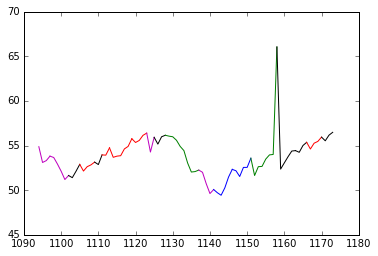

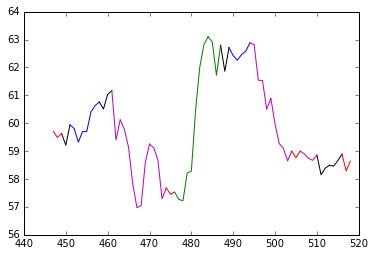

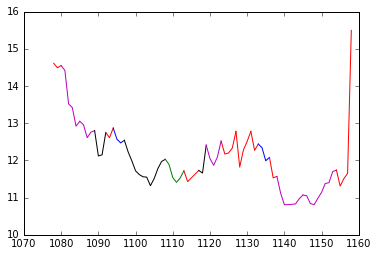

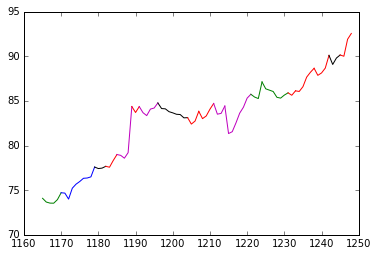

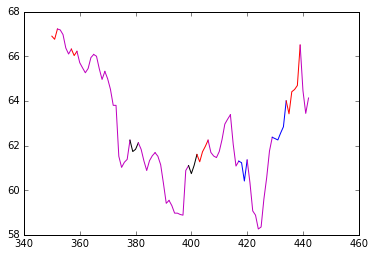

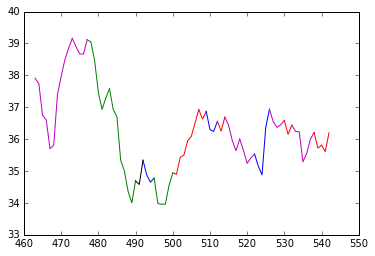

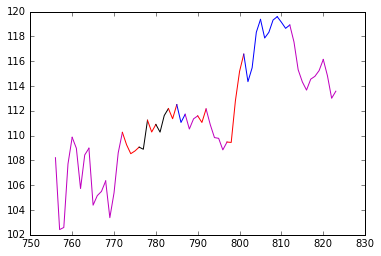

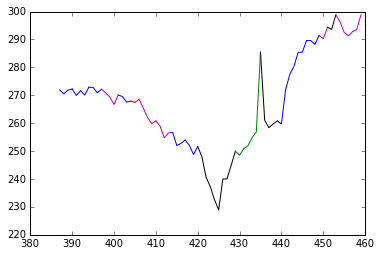

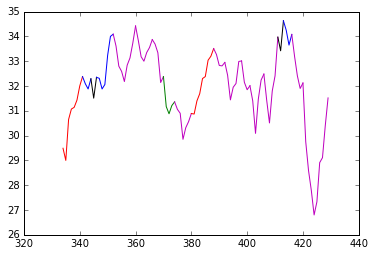

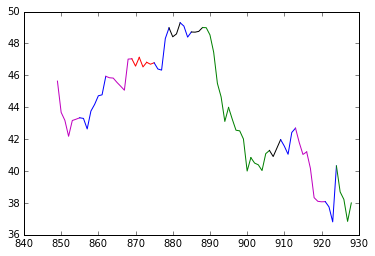

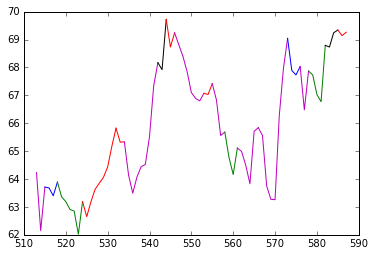

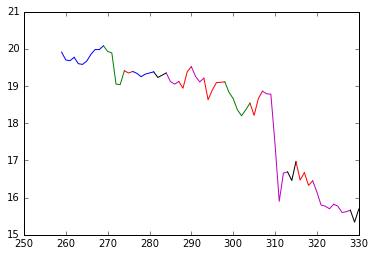

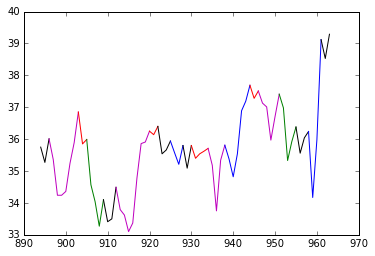

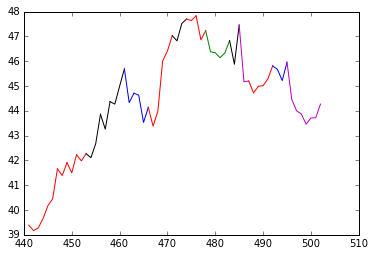

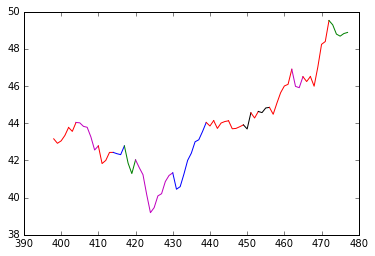

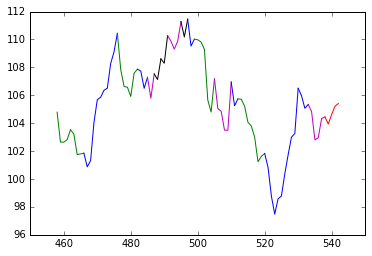

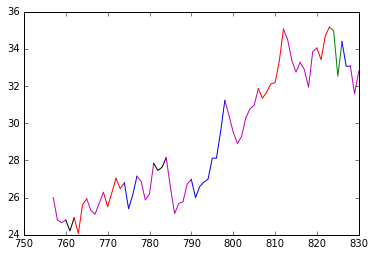

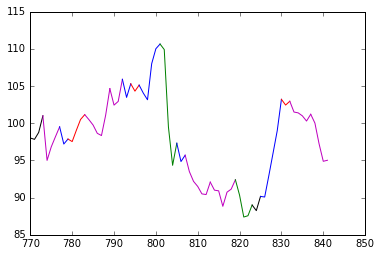

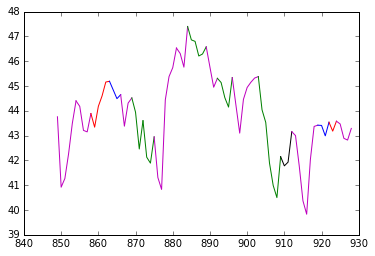

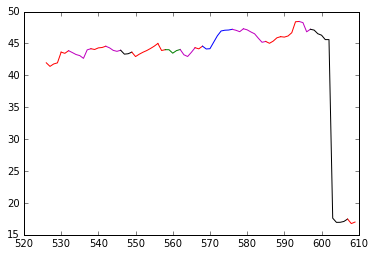

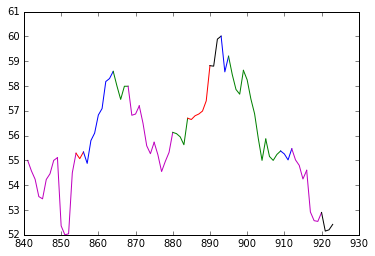

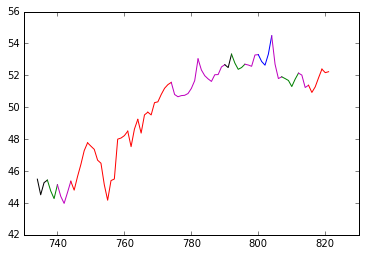

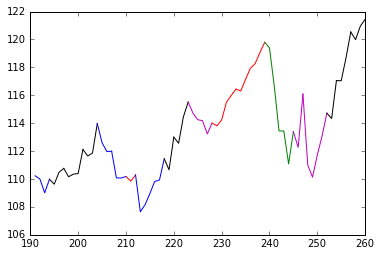

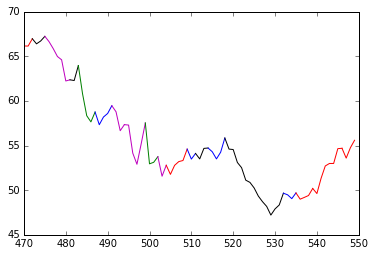

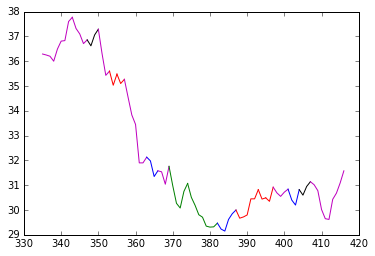

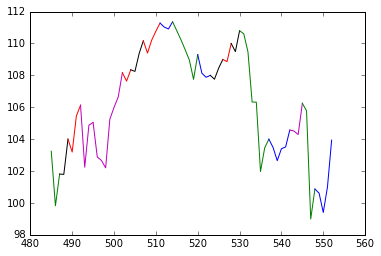

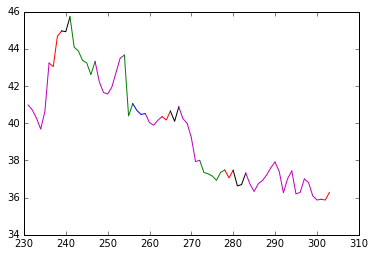

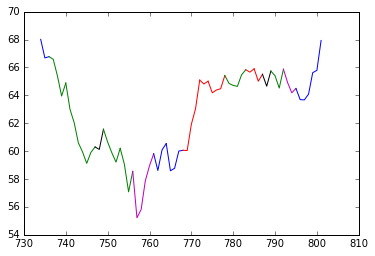

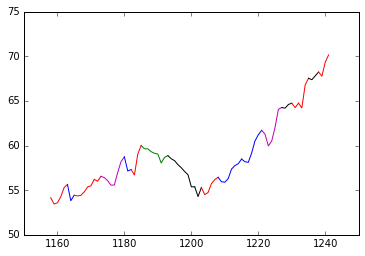

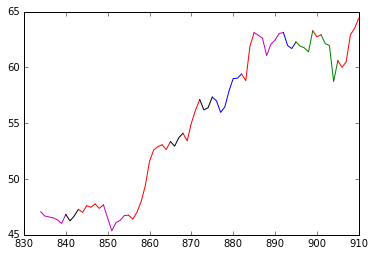

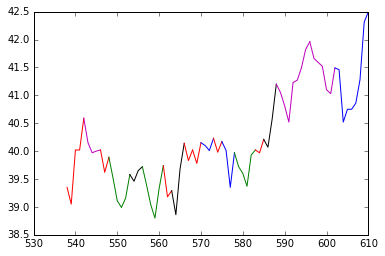

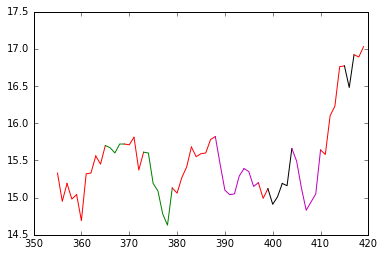

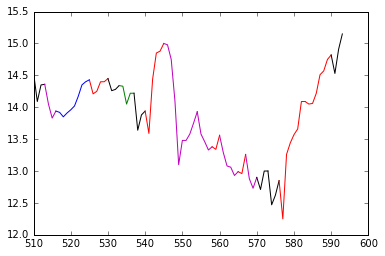

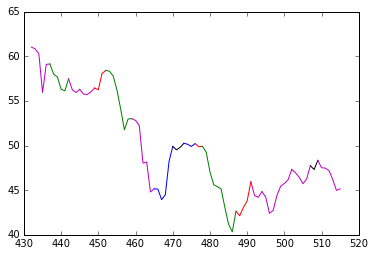

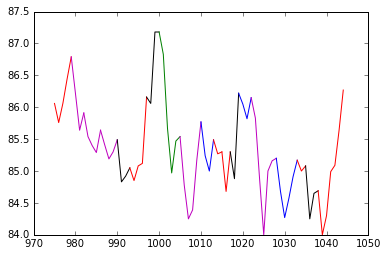

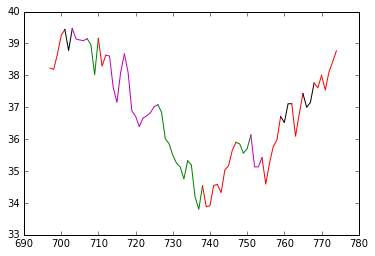

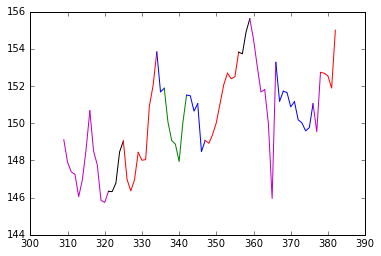

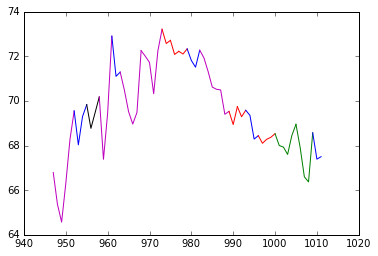

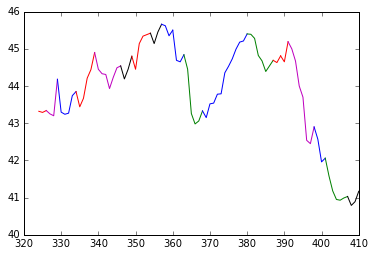

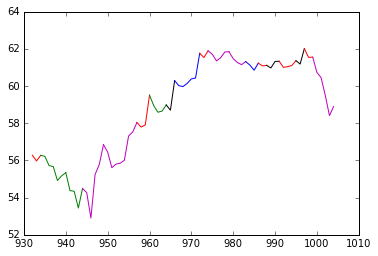

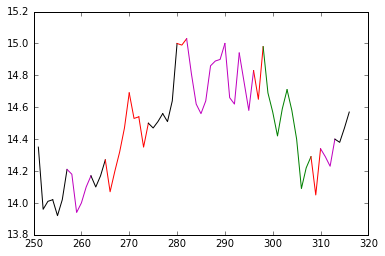

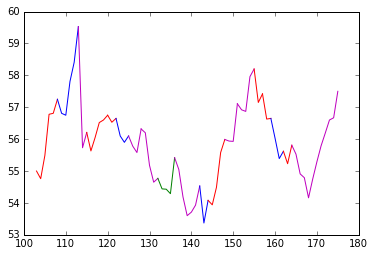

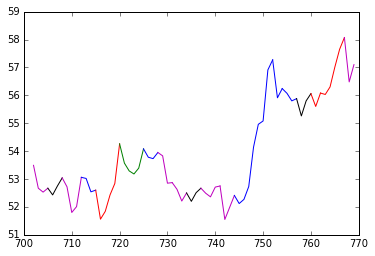

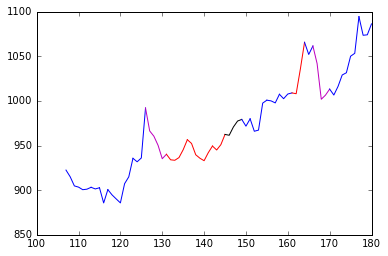

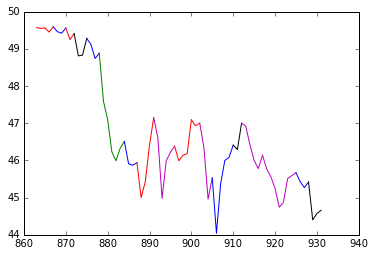

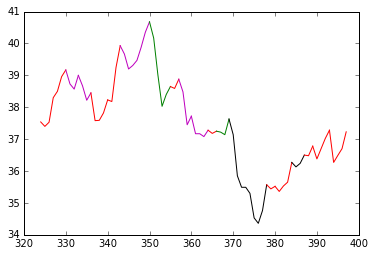

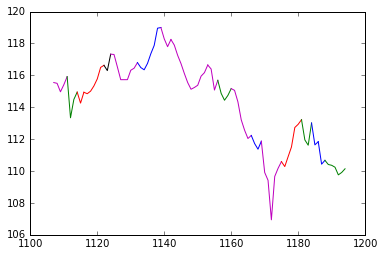

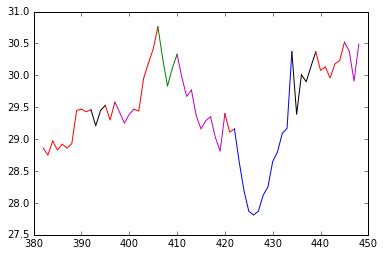

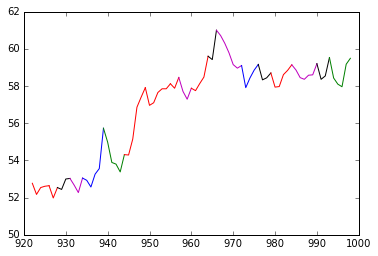

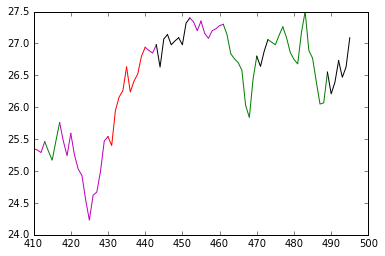

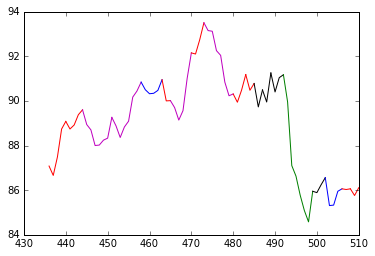

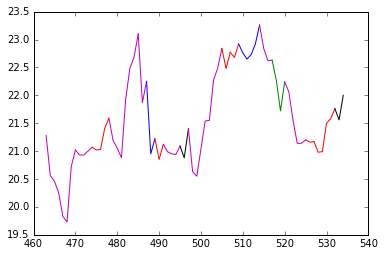

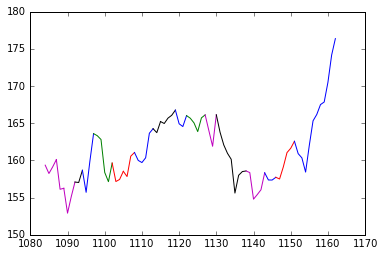

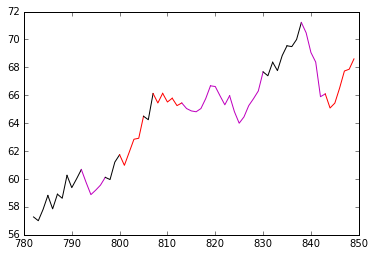

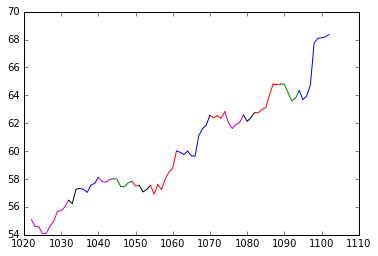

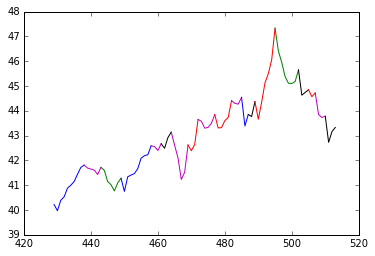

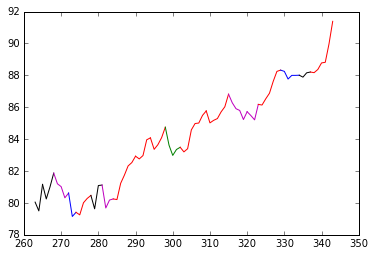

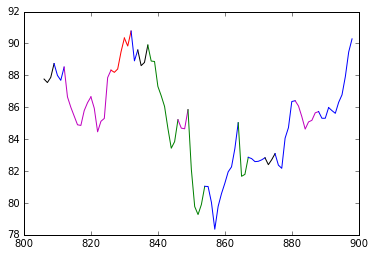

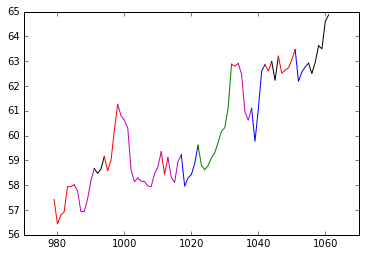

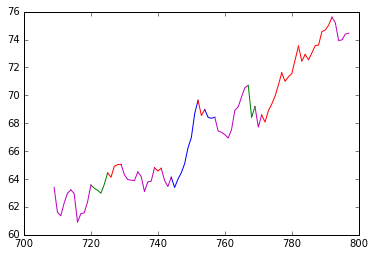

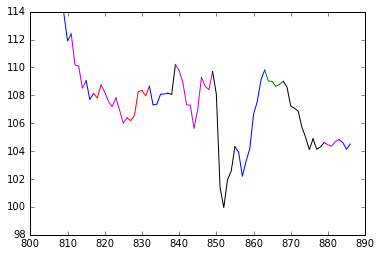

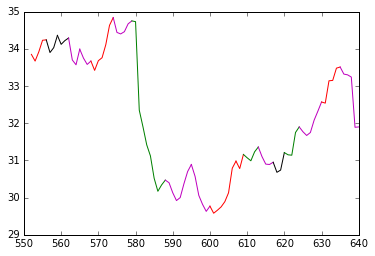

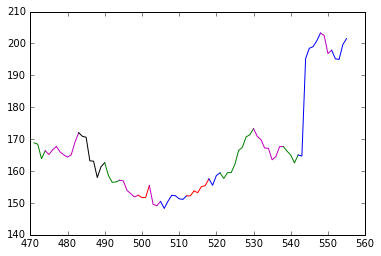

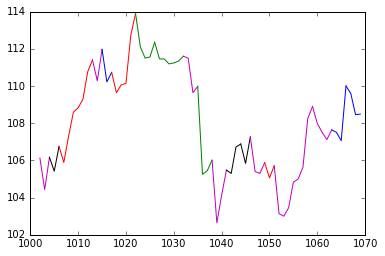

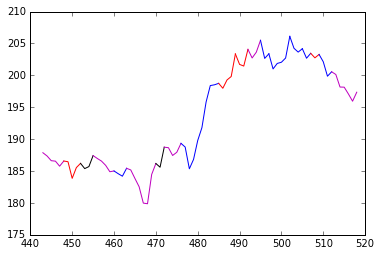

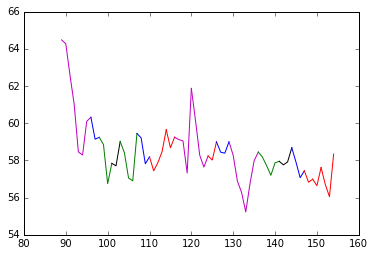

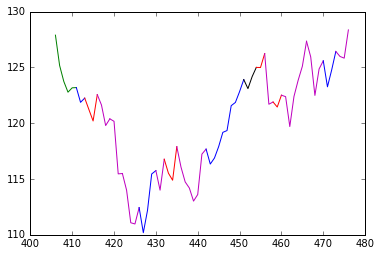

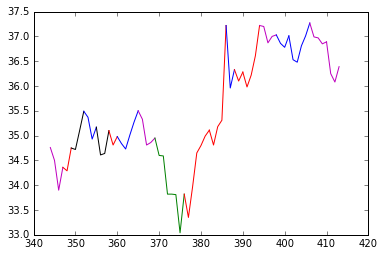

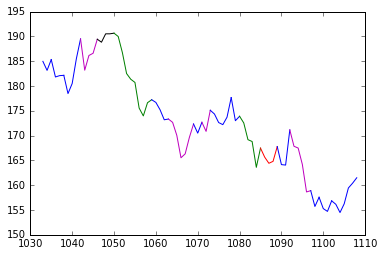

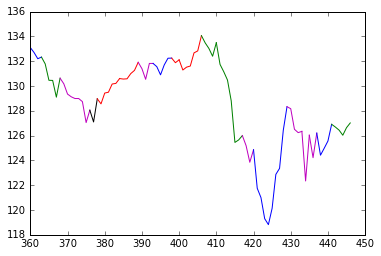

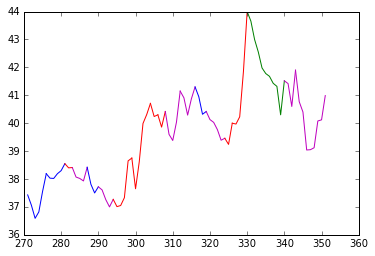

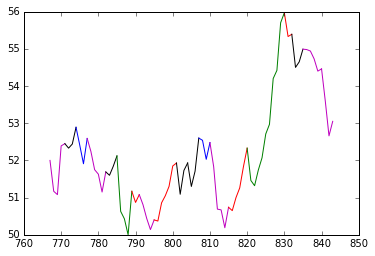

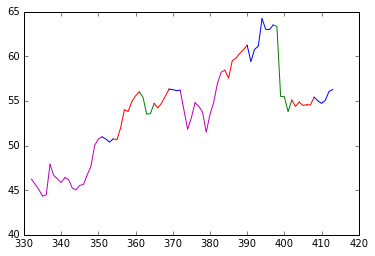

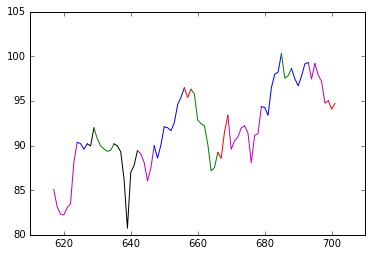

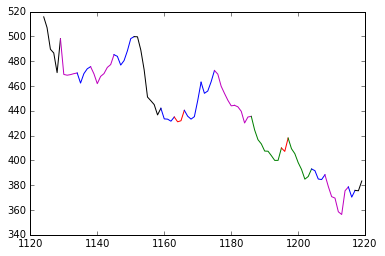

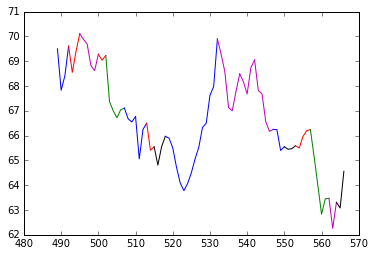

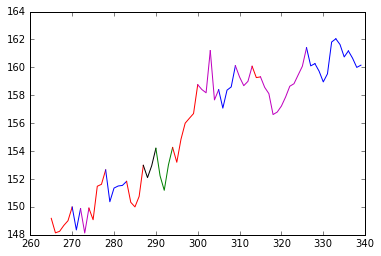

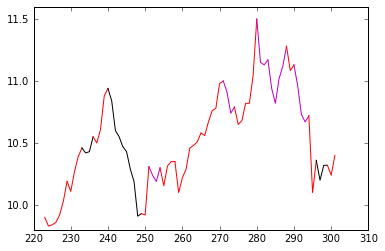

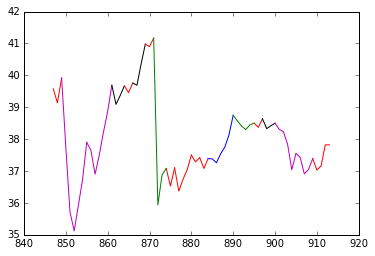

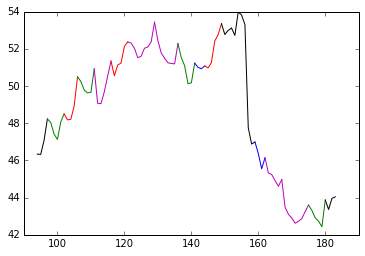

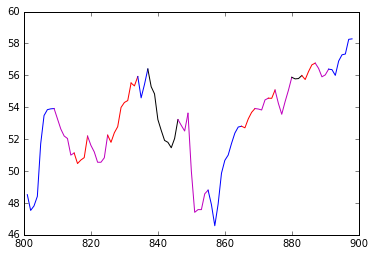

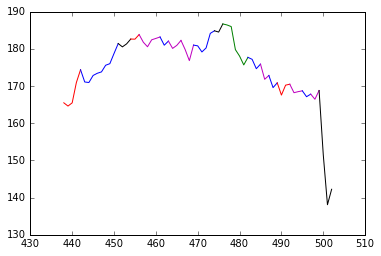

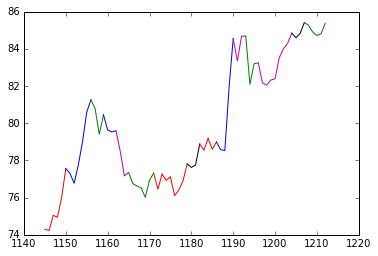

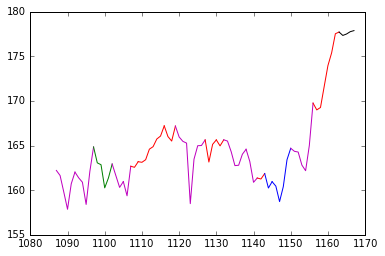

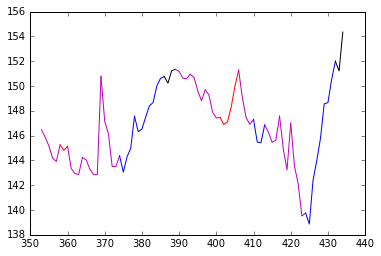

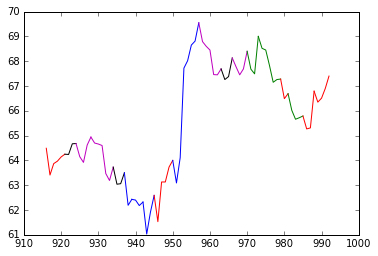

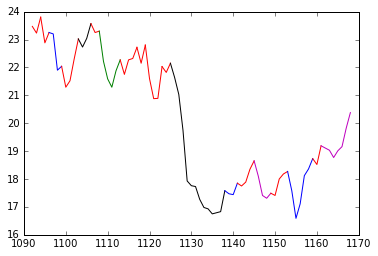

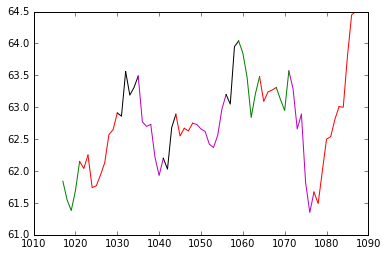

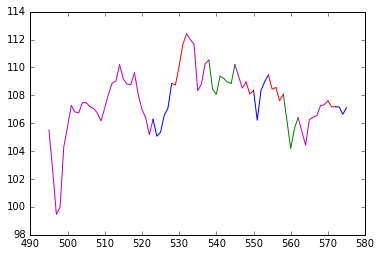

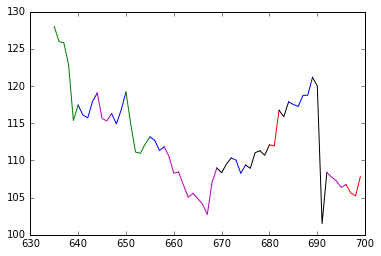

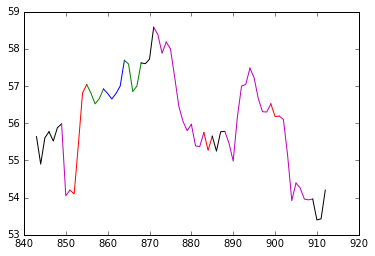

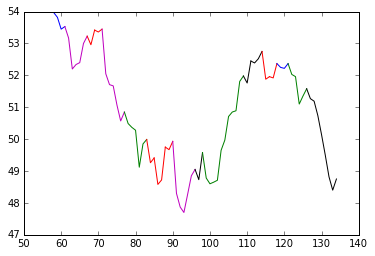

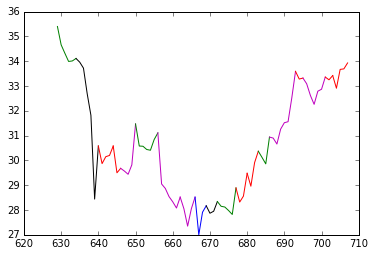

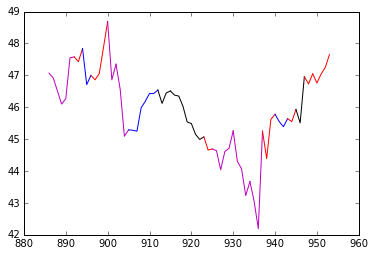

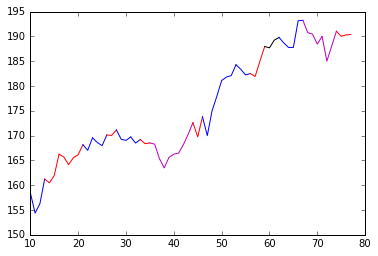

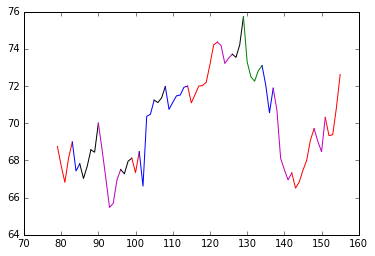

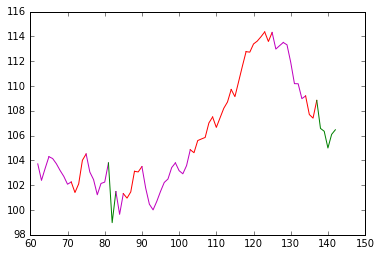

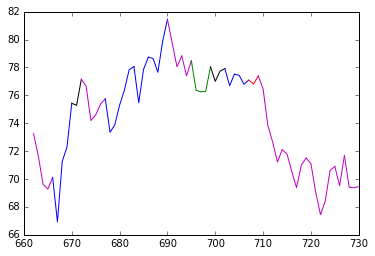

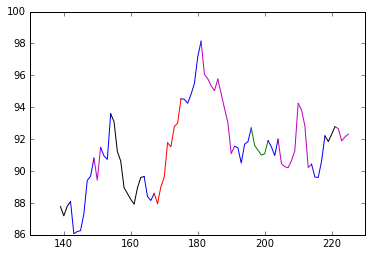

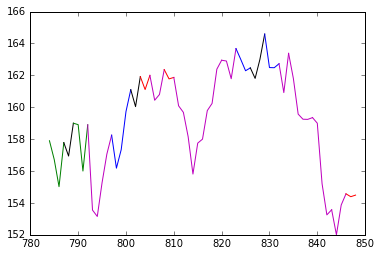

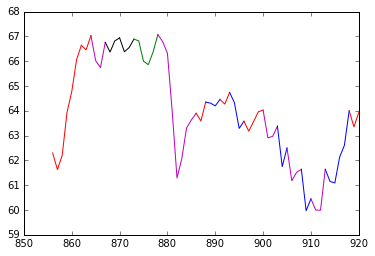

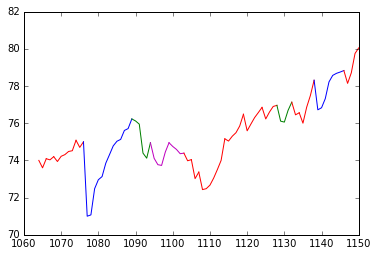

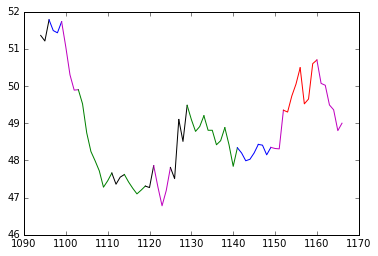

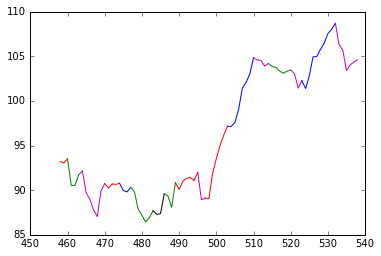

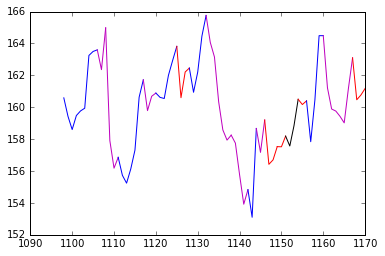

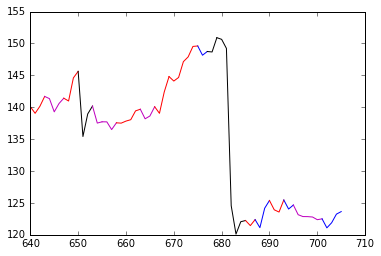

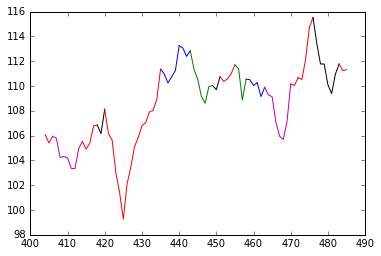

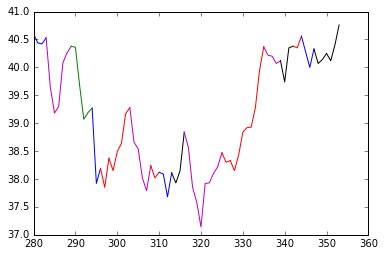

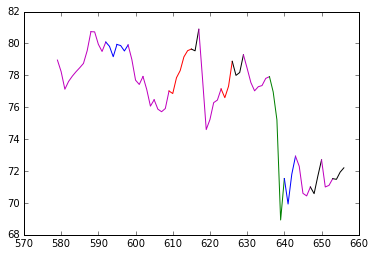

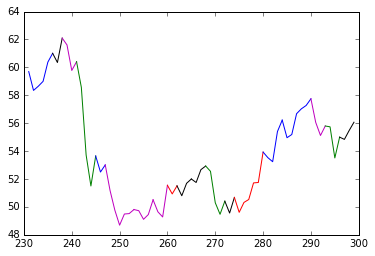

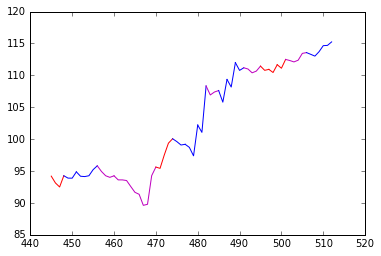

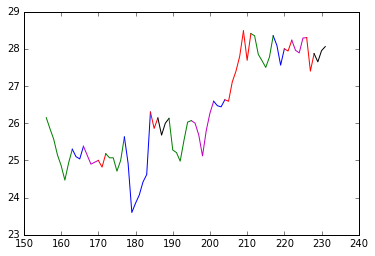

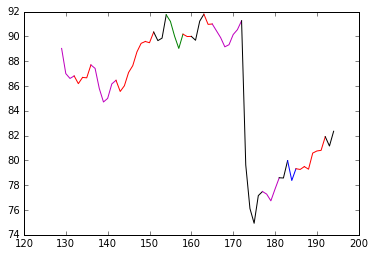

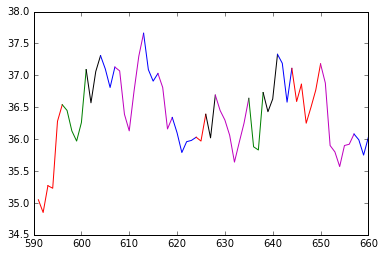

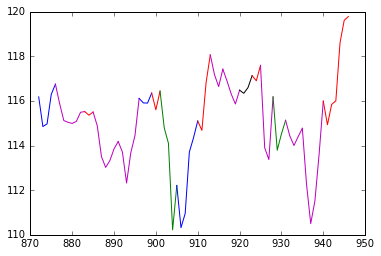

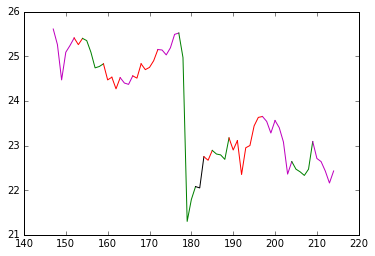

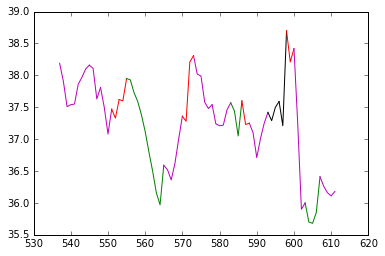

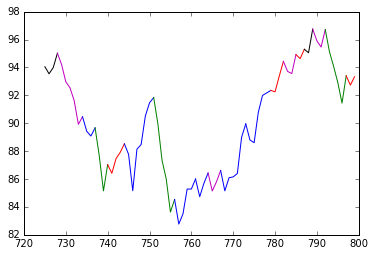

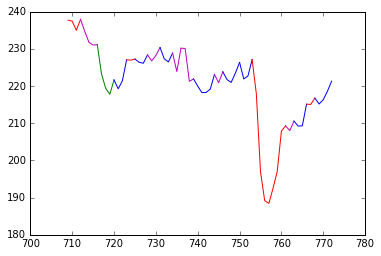

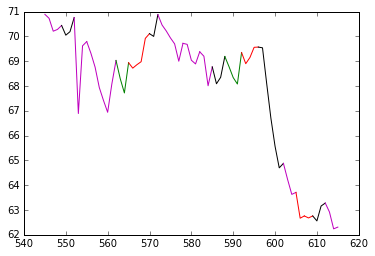

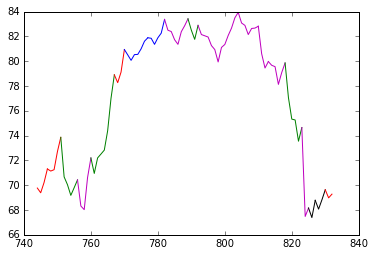

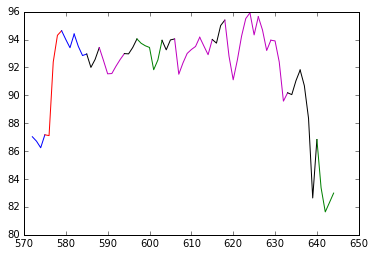

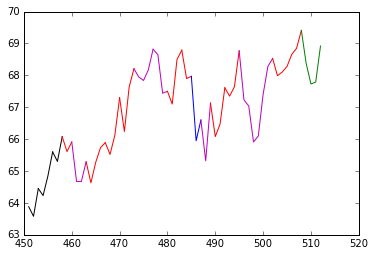

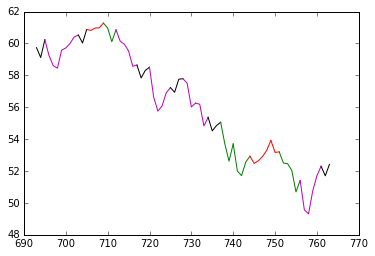

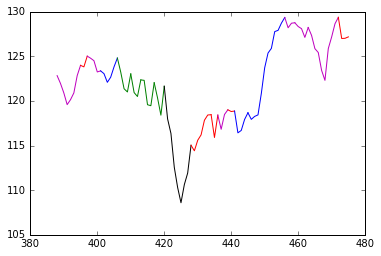

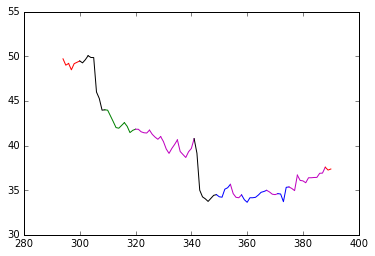

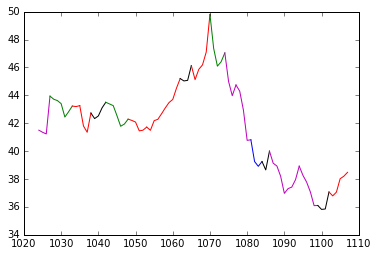

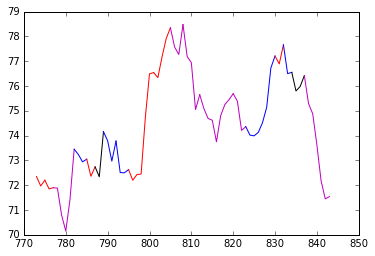

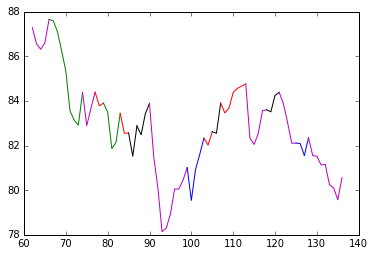

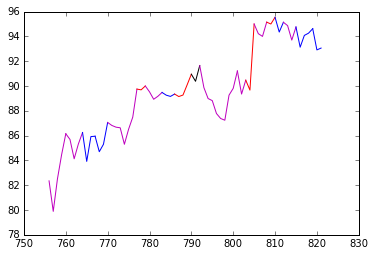

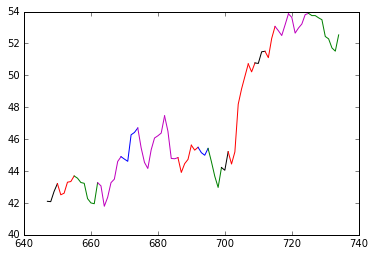

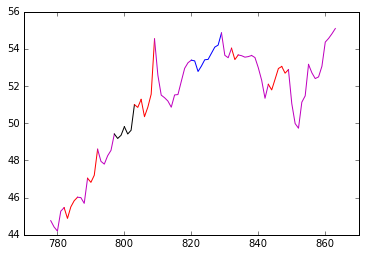

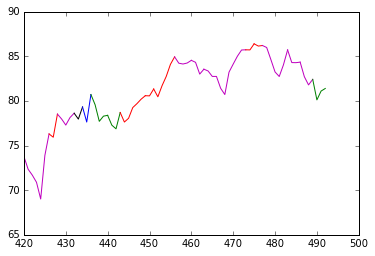

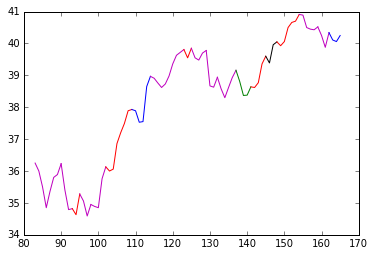

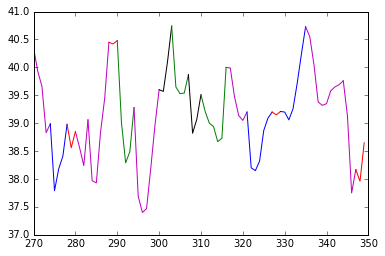

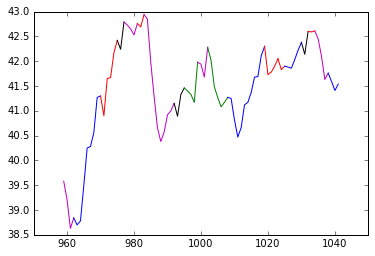

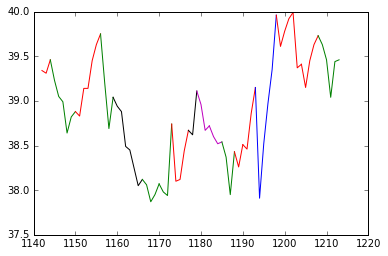

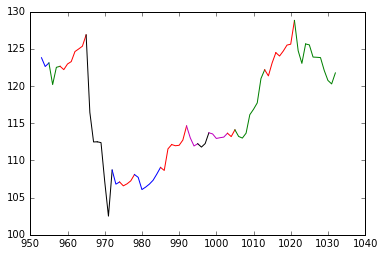

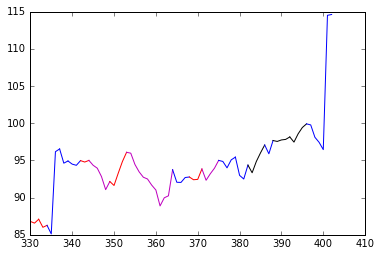

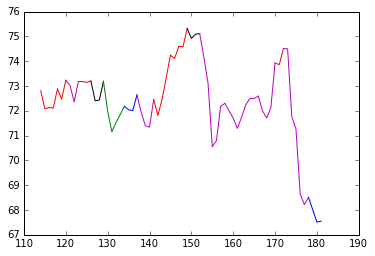

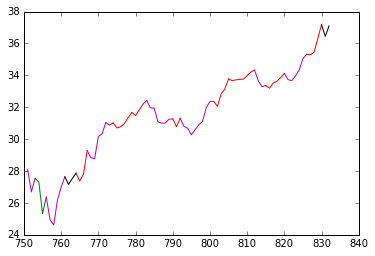

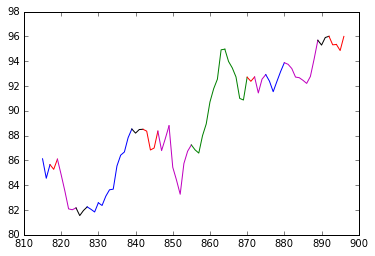

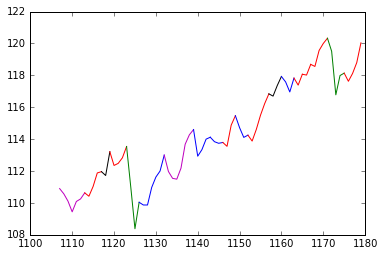

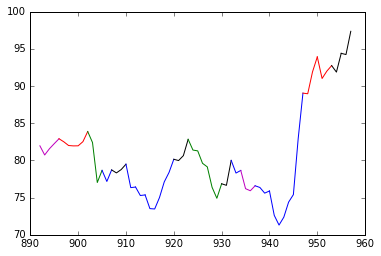

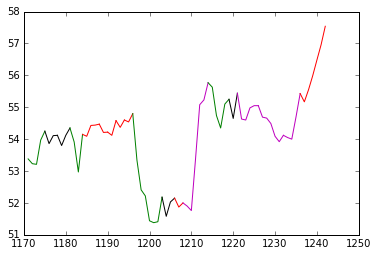

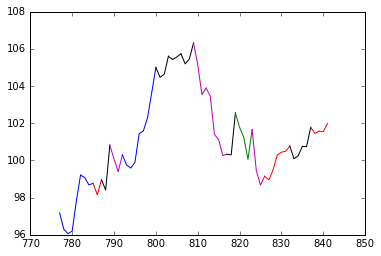

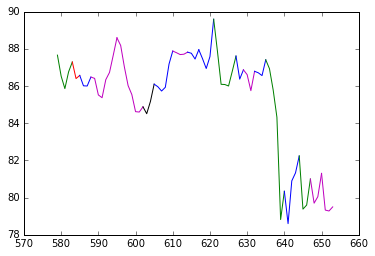

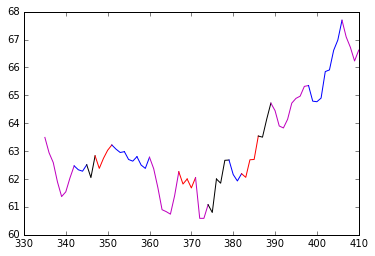

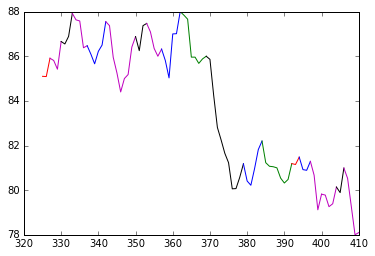

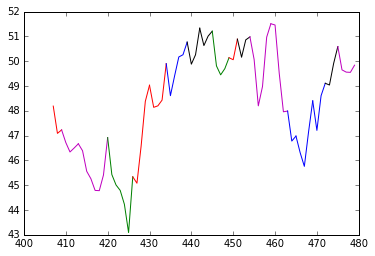

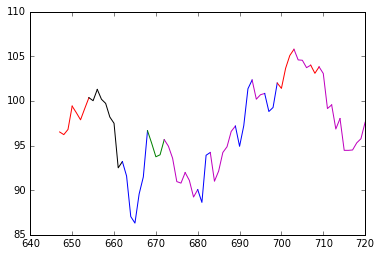

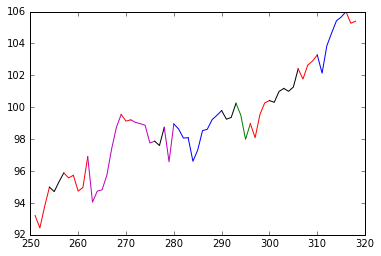

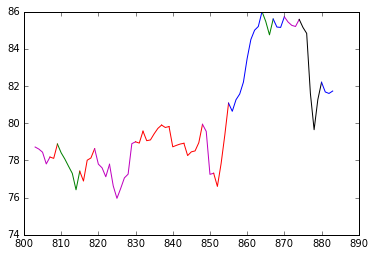

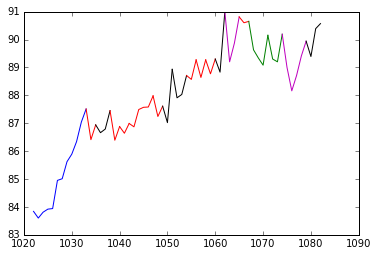

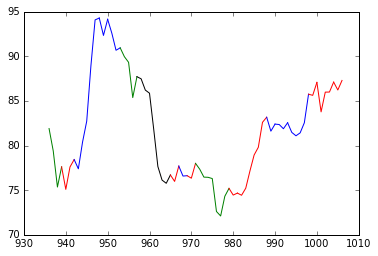

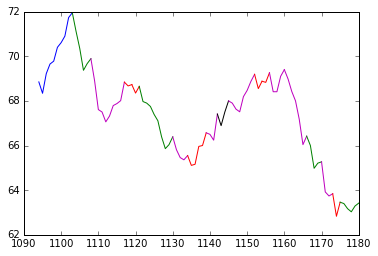

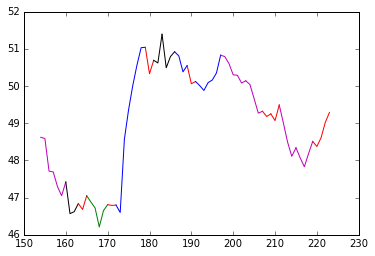

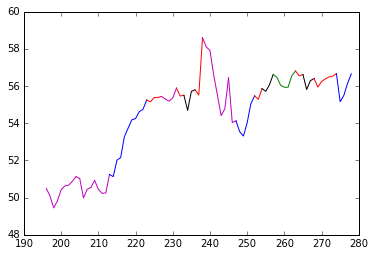

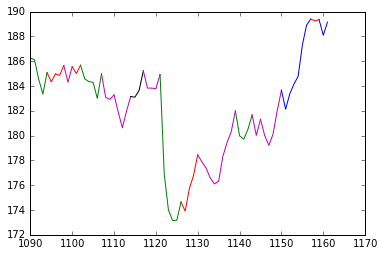

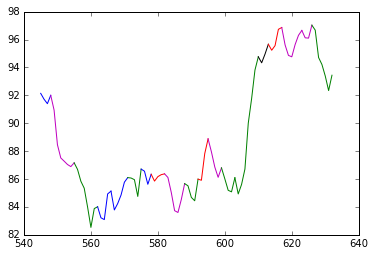

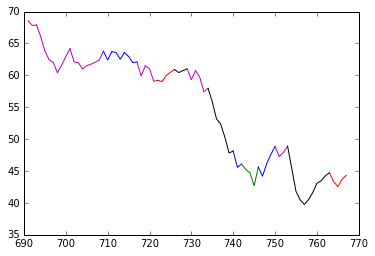

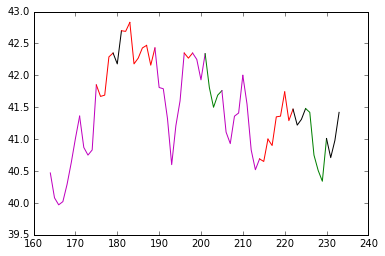

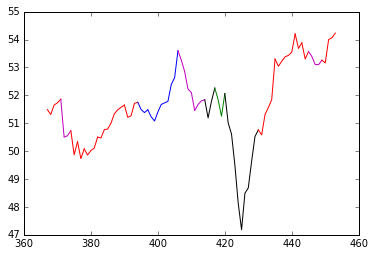

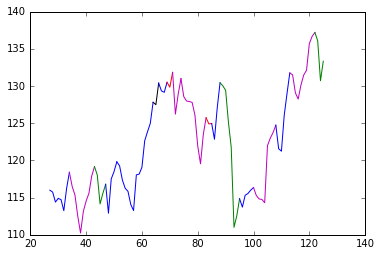

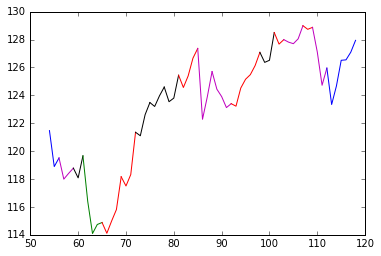

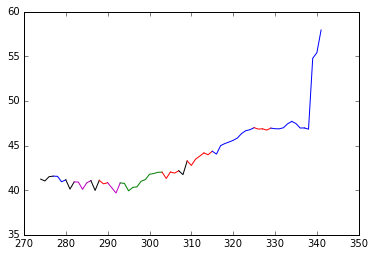

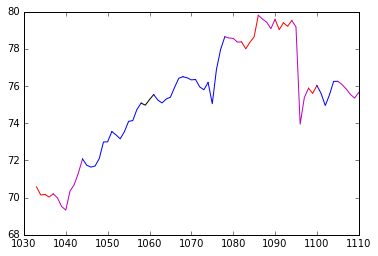

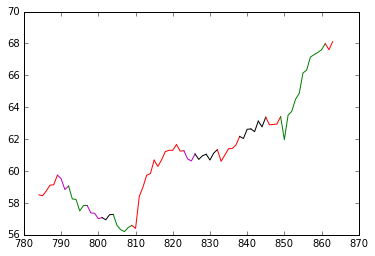

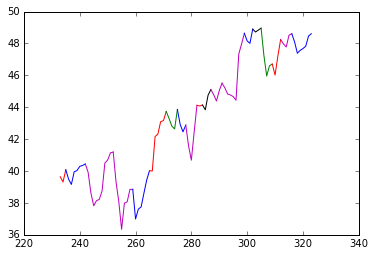

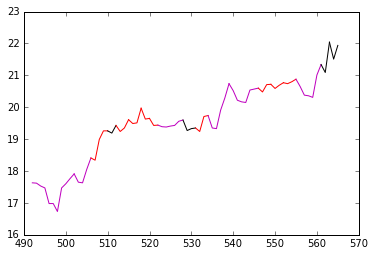

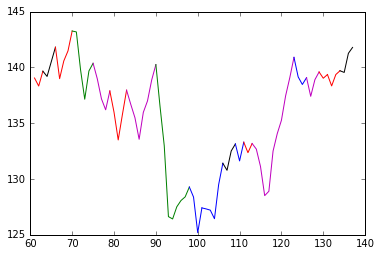

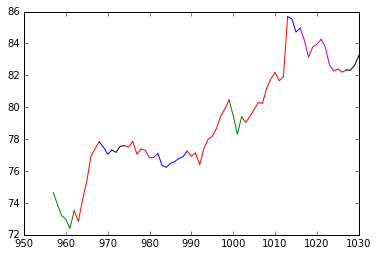

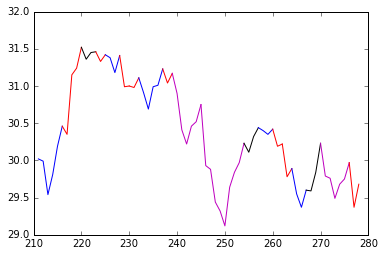

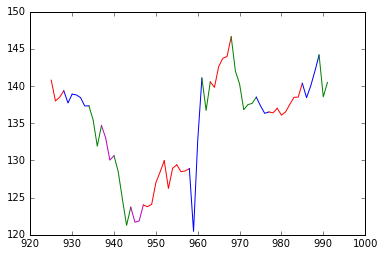

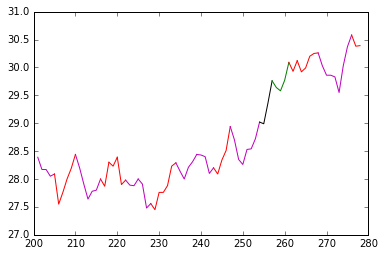

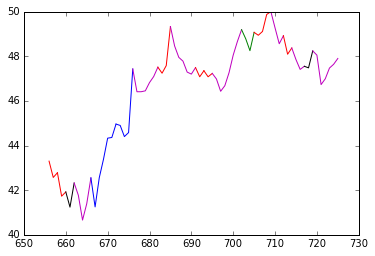

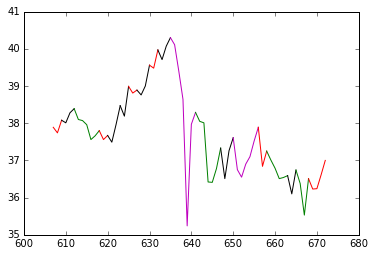

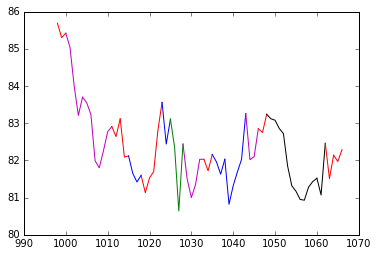

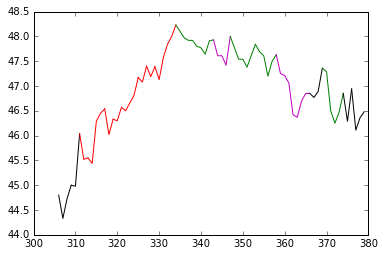

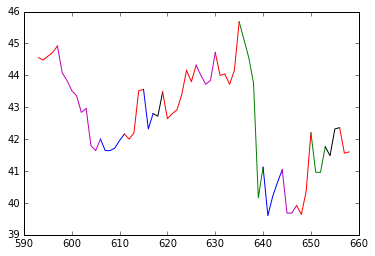

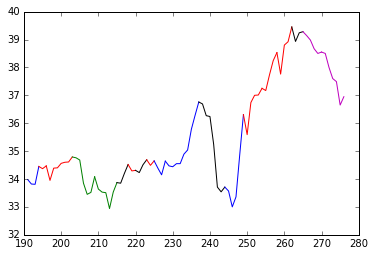

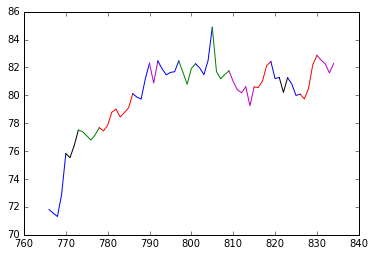

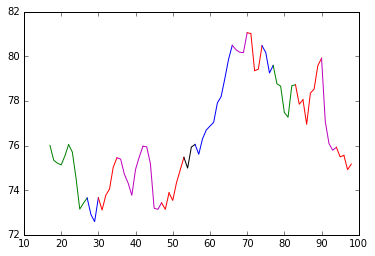

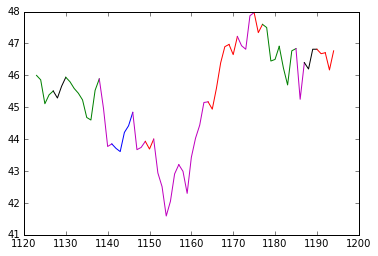

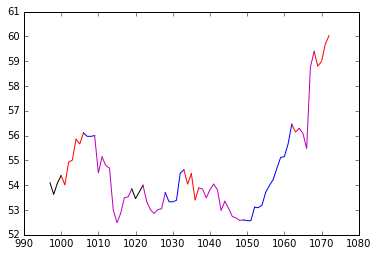

In [25]:
file_dir = 'individual_stocks_5yr'
files = [os.path.basename(elem) for elem in sorted(glob.glob(file_dir+'/*.csv'))]

for filename in files:
    if 'APTV' not in filename and 'FTV' not in filename and 'UA' not in filename:
        file = file_dir + '/' + filename
        data = read_data(file)
        Vs, Pts = get_Vectors(data)
        Ss = [getScale(v) for v in Vs]
        G = getLRThreshold(np.array(Ss))
        Gs = categorizeV(G, labels)
        
        # Random the section of data to visualize, since the whole data is difficult to interpret visually.
        r = np.random.randint(0, len(Pts)-20) 
        
        visualizeData(data, Pts[r:r+20], Gs[r:r+20])